## Process:
Prerequesits:
1. Loading data
2. Visualising raw data

#### Inference of Passive Elements
Replicating observed traces:
1. Defining current used in clamping 
    - fitting $\tau$, $R_{in}$, setting C and calculating A
2. Simulate passive membrane dynamics
3. Calculate summary stats
4. match simulation to observations by random search / or possible smarter?
    - compare summary stats and traces
5. choose prior to cover observed summary statistics
    - simulate different parameter combinations, extract summary stats, plot historgram of results, compare to experimentally observed values

SNPE or similar method for inference on passive elements:
1. hand pick only the good summary stats
2. use prior, run simulator, infer posterior, sample from posterior
    - visualise by pairplot and/or histogramm
    - simulate traces from the posterior sampled parameters and plot along with original trace. 
    - plot histogram of summary stats. Are observed stats covered?

#### Inference of active elements
Replicating observed traces:
1. if posterior sample fits observed data well, use on different trace, i.e. different stimulation. adjust leak conductance if necessary, to fit second trace well also
2. now follows the same procedure as for passive inference:
    1. Define current
    2. run HH_simulator to simulate active dynamics
    3. calculate summary stats
    4. match simulation to observations
    5. choose prior to cover observed statistics

SNPE or similar method for inference on active elements:
1. use summary stats for which there is a prior support, check which of the summary stats have the smallest Euclidian distance to observed summary stats
2. hand pick good summary stats
3. use prior, construct model (i.e. with MAF), run SNPE, infer posterior, sample from posterior

#### Find compensation mechanisms somehow

### ISSUES
- implement automatic selection of electrode?
- Units !
- Add Units in [] to summary stats dict
- Simulator should take in Cell or params + trace and output Trace() -> modify
- best_matches is really slow!!

### Imports

In [3]:
import numpy as np
import torch
from scipy.io import loadmat
import importlib
import pandas as pd
import importlib # mainly for reloading modules on the fly

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# sbi
import sbi.utils as utils
from sbi.inference import SNPE, prepare_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi.analysis import pairplot,conditional_pairplot, conditional_corrcoeff, eval_conditional_density
from sbi.inference.posteriors.direct_posterior import DirectPosterior

from copy import deepcopy


# summary stats extraction
import EphysSBIHelper.ephys_extractor as efex
import EphysSBIHelper.ephys_features as ft

# fit curves
from scipy.optimize import curve_fit

# to calculate moments
from scipy import stats as spstats

# parallel processing
from joblib import Parallel, delayed
from tqdm.auto import tqdm

# warning handlings
import warnings

# Brian2
import brian2 as br2
br2.prefs.codegen.target = 'cython' # for C compile. Alternatively use "numpy" 

from EphysDataHelper.simulators import HHsimulatorWrapper as HHsimulatorWrapper # HH model C wrapper

In [15]:
# remove top and right axis from plot
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

### Simulators

In [16]:
def HHsimulator(model_params, seed, V0, I, dt, t_fin): 
    """Adpated from code courtesy of @ybernaerts."""
    t_start = 0
    t_dur = t_fin - t_start
    size = int(t_dur/dt)+1
    model_params = np.array(model_params).reshape(-1)
    # parameters to be inferred
    
    # Maximum sodium concuctance
    gbar_Na = model_params[0] # mS/cm2
    gbar_Na.astype(float)
    
    # Maximum potassium concuctance
    gbar_K = model_params[1] # mS/cm2
    gbar_K.astype(float)
    
    # Maximum conductance for adaptive potassium currents (these can induce firing rate adaptations)
    gbar_M = model_params[2] # mS/cm2
    gbar_M.astype(float)
    
    # Leak conductance
    g_leak = model_params[3] # mS/cm2
    g_leak.astype(float)
    
    # time constant of the adaptive potassium current (gives an idea of when these channels will turn active)
    tau_max = model_params[4] # ms
    tau_max.astype(float)
    
    # Vt: a 'threshold' voltage that can influence the dynamics of all channels
    Vt = model_params[5] # mV
    Vt.astype(float)
    
    # Leak potential
    E_leak = model_params[6] # mV
    E_leak.astype(float)
    
    # A factor that can change the amount of injected current, or equivalently change the compartment area initially
    # deduced if it sees fit to do so
    #I_scale = model_params[0,7]
    #I_scale.astype(float)
    
    # A factor that can make the dynamics of Na+ and K+ channels faster/slower. This was included to find simulations
    # that can recover the shape of the 1st action potential fired. 
    rate_to_SS_factor = model_params[7]
    rate_to_SS_factor.astype(float)
    
    # fixed parameters (g_leak, C from fitting hyperpolarization trace)
    #g_leak = 0.117  # mS/cm2
    #Vt = -60.0  # mV
    #E_leak = np.mean(voltage_obs[0:2500, curr_index])  # mV
    nois_fact = 0.1  # uA/cm2
    C = 1  # uF/cm2
    E_Na = 53  # mV            # TODO: check with Federico
    E_K = -90  # mV            # TODO: check with Federico
    Q10=3
    T_1 = 36                           # °C, from paper Martin Pospischil et al.
    T_2 = 34                           # °C, experiment was actually done at 34 °C
    T_adj_factor = Q10**((T_2-T_1)/10) # temperature coeff., https://en.wikipedia.org/wiki/Q10_(temperature_coefficient)
    
    tstep = float(dt)    
    
    if seed is not None:
        rng = np.random.RandomState(seed=seed)
    else:
        rng = np.random.RandomState()

    ####################################
    # kinetics
    def efun(z):
        if np.abs(z) < 1e-4:
            return 1 - z / 2
        else:
            return z / (np.exp(z) - 1)

    def alpha_m(x):
        v1 = x - Vt - 13.0
        return 0.32 * efun(-0.25 * v1) / 0.25

    def beta_m(x):
        v1 = x - Vt - 40
        return 0.28 * efun(0.2 * v1) / 0.2

    def alpha_h(x):
        v1 = x - Vt - 17.0
        return 0.128 * np.exp(-v1 / 18.0)

    def beta_h(x):
        v1 = x - Vt - 40.0
        return 4.0 / (1 + np.exp(-0.2 * v1))

    def alpha_n(x):
        v1 = x - Vt - 15
        return 0.032 * efun(-0.2 * v1) / 0.2

    def beta_n(x):
        v1 = x - Vt - 10.0
        return 0.5 * np.exp(-v1 / 40)

    # steady-states and time constants
    def tau_n(x):
        return rate_to_SS_factor*1 / (alpha_n(x) + beta_n(x))

    def n_inf(x):
        return alpha_n(x) / (alpha_n(x) + beta_n(x))

    def tau_m(x):
        return rate_to_SS_factor*1 / (alpha_m(x) + beta_m(x))

    def m_inf(x):
        return alpha_m(x) / (alpha_m(x) + beta_m(x))

    def tau_h(x):
        return rate_to_SS_factor*1 / (alpha_h(x) + beta_h(x))

    def h_inf(x):
        return alpha_h(x) / (alpha_h(x) + beta_h(x))

    # slow non-inactivating K+
    def p_inf(x):
        v1 = x + 35.0
        return 1.0 / (1.0 + np.exp(-0.1 * v1))

    def tau_p(x):
        v1 = x + 35.0
        return tau_max / (3.3 * np.exp(0.05 * v1) + np.exp(-0.05 * v1))

    ####################################
    # simulation from initial point
    V = np.zeros(size)  # voltage
    n = np.zeros(size)
    m = np.zeros(size)
    h = np.zeros(size)
    p = np.zeros(size)

    V[0] = float(V0)
    n[0] = n_inf(V[0])
    m[0] = m_inf(V[0])
    h[0] = h_inf(V[0])
    p[0] = p_inf(V[0])

    for i in range(1, size):
        tau_V_inv = (
            (m[i - 1] ** 3) * gbar_Na * h[i - 1]
            + (n[i - 1] ** 4) * gbar_K
            + g_leak
            + gbar_M * p[i - 1]
        ) / C
        V_inf = (
            (m[i - 1] ** 3) * gbar_Na * h[i - 1] * E_Na
            + (n[i - 1] ** 4) * gbar_K * E_K
            + g_leak * E_leak
            + gbar_M * p[i - 1] * E_K
            + I[i - 1]
            + nois_fact * rng.randn() / (tstep ** 0.5)
        ) / (tau_V_inv * C)
        V[i] = V_inf + (V[i - 1] - V_inf) * np.exp(-tstep * tau_V_inv)
        n[i] = n_inf(V[i]) + (n[i - 1] - n_inf(V[i])) * np.exp((-tstep*T_adj_factor / tau_n(V[i])))
        m[i] = m_inf(V[i]) + (m[i - 1] - m_inf(V[i])) * np.exp((-tstep*T_adj_factor / tau_m(V[i])))
        h[i] = h_inf(V[i]) + (h[i - 1] - h_inf(V[i])) * np.exp((-tstep*T_adj_factor / tau_h(V[i])))
        p[i] = p_inf(V[i]) + (p[i - 1] - p_inf(V[i])) * np.exp((-tstep*T_adj_factor / tau_p(V[i])))

        Vs = np.array(V)
    return Vs

In [17]:
def HH_Br2(model_params, V0, A, ItA, dt, t_fin): 
    """Run the Hodgkin Huxley model with provided parameters and stimulation
    protocol. Brian2 Implementation.
    
    Adpated from code courtesy of @ybernaerts.

    Parameters
    ----------
    model_params : ndarray
        .Parameter vector that contains the HH model parameters.

    Returns
    -------
    t, Vm, I_inj : np.ndarray
        Timepoints, membrane voltage and the injected current are returned."""
    
    model_params = np.asarray(model_params, float)
    N = model_params.shape[0]
    
    ####################
    # Setting up the injection current, the model equations, further initialisations and run the model ;)
    
    I = br2.TimedArray(np.vstack( [[ItA]*N] ).T, dt = dt*br2.msecond)
    
    # The conductance-based model
    eqs = '''
         dVm/dt = -(gNa*m**3.0*h*(Vm - ENa) + gK*n**4.0*(Vm - EK) + gleak*(Vm - El) - I_inj + 
                   (gM*p*(Vm - EK))) / C : volt
                   
         I_inj = I(t, i)*pA : amp
         
         dm/dt = (alpham*(1.0-m) - betam*m) * t_adj_factor / rate_to_SS_factor : 1
         dn/dt = (alphan*(1.0-n) - betan*n) * t_adj_factor / rate_to_SS_factor : 1
         dh/dt = (alphah*(1.0-h) - betah*h) * t_adj_factor / rate_to_SS_factor : 1
         dp/dt = ((p_inf - p)/tau_p) * t_adj_factor : 1

         alpham = (-0.32/mV) * (Vm - VT - 13.0*mV) / (exp((-(Vm - VT - 13.0*mV))/(4.0*mV)) - 1.0)/ms : Hz
         betam = (0.28/mV) * (Vm - VT - 40.0*mV) / (exp((Vm - VT - 40.0*mV)/(5.0*mV)) - 1.0)/ms : Hz

         alphah = 0.128 * exp(-(Vm - VT - 17.0*mV) / (18.0*mV))/ms : Hz
         betah = 4.0/(1.0 + exp((-(Vm - VT - 40.0*mV)) / (5.0*mV)))/ms : Hz

         alphan = (-0.032/mV) * (Vm - VT - 15.0*mV) / (exp((-(Vm - VT - 15.0*mV)) / (5.0*mV)) - 1.0)/ms : Hz
         betan = 0.5*exp(-(Vm - VT - 10*mV) / (40*mV))/ms : Hz

         p_inf = 1.0/(1.0 + exp(-(Vm + 35.0*mV)/(10.0*mV))) : 1
         tau_p = (tau_max/1000.0)/(3.3 * exp((Vm + 35.0*mV)/(20.0*mV)) + exp(-(Vm + 35.0*mV)/(20.0*mV))) : second
         
         gNa : siemens
         gK : siemens
         gleak : siemens
         gM : siemens
         tau_max : second
         VT : volt
         El : volt
         rate_to_SS_factor : 1
         C : farad
         
         ENa : volt (shared)
         EK : volt (shared)
         
         t_adj_factor : 1 (shared)
         '''
    neurons = br2.NeuronGroup(N, eqs, method='exponential_euler', name='neurons', dt=dt*br2.msecond)
    
    ###################
    # Model parameter initialisations
    # Some are set, some are performed inference on
    # Inspired by Martin Pospischil et al. "Minimal Hodgkin-Huxley type models for
    # different classes of cortical and thalamaic neurons".
    area = A*br2.umetre**2  # um2
    
    neurons.gNa = model_params[:,0]*br2.mS/br2.cm**2*area
    neurons.gK = model_params[:,1]*br2.mS/br2.cm**2*area
    neurons.gM = model_params[:,2]*br2.mS/br2.cm**2*area
    neurons.gleak = model_params[:,3]*br2.mS/br2.cm**2*area
    neurons.tau_max = model_params[:,4]*br2.second
    neurons.VT = model_params[:,5]*br2.mV
    neurons.El = model_params[:,6]*br2.mV
    neurons.C = 1.0*br2.uF/br2.cm**2*area
    neurons.rate_to_SS_factor = model_params[:,7]
    
    neurons.Vm = V0*br2.mV #V0
    
    neurons.ENa = 53.0*br2.mV
    neurons.EK = -90.0*br2.mV
    
    # It is important to adapt your kinetics to the temperature of your experiment
    # temperature coeff., https://en.wikipedia.org/wiki/Q10_(temperature_coefficient)
    T_1 = 36.0        # °C, from paper MartinPospischil et al.
    T_2 = 34.0        # °C, experiment was actually done at 25 °C
    Q10 = 3.0           # temperature coeff.
    
    neurons.t_adj_factor = Q10**((T_2 - T_1)/10.0)
    
    # set monitoring
    Vm_mon = br2.StateMonitor(neurons, ['Vm', 'I_inj'], record = True, name = 'Vm_mon') # Specify what to record
    
    
    # init
    neurons.m = '1/(1 + betam/alpham)'         # Would be the solution when dm/dt = 0
    neurons.h = '1/(1 + betah/alphah)'         # Would be the solution when dh/dt = 0
    neurons.n = '1/(1 + betan/alphan)'         # Would be the solution when dn/dt = 0
    neurons.p = 'p_inf'                        # Would be the solution when dp/dt = 0
    
    # run simulation
    br2.run(t_fin*br2.ms)
    
    return Vm_mon.t/br2.ms, Vm_mon.Vm/br2.mV, Vm_mon.I_inj/br2.pA

### Simutils

In [2]:
def prepare_HH_input(x):
    """Takes input vector to the HH simulator and
    tests whether it conforms with the neccessary
    shape. If not, it will be reshaped accordingly
    so it possess a shape of of (1,-1).

    Parameters
    ----------
    x : numpy.ndarray or torch.tensor or list
        Inputparameters to the HH.

    Returns
    -------
    x : torch.tensor
        Appropriately reshaped input to the HH."""

    if type(x) == np.ndarray:
        x = torch.tensor(x)

    num_dim = x.dim()

    if num_dim == 1:
        x = x.reshape(1,-1)
    return x

def runHH(model_params, trace=None, syn_current=None, using="C++", mode="auto"):
    """Run the Hodgkin Huxley model with provided parameters and stimulation
    protocol and simulate the behaviour of the membrane voltage.
    Runs C code in the backend or via Brian2.

    Parameters
    ----------
    model_params : ndarray
        .Parameter vector that contains the HH model parameters.
    trace : Trace
        Trace object for the observed voltage trace, containing all relevant values
        of the stimulation protocol.
    syn_current : dict
        Contains the initial current "V0" [float], the stimulation current trace
        "It" [ndarray], the product of the stimulation current trace and the area
        of the soma "ItA": ndarray, the time axis "ts": ndarray, the step size
        "dt": float and the simulus time course "StimOnset": float,
        "StimEnd": float and "StimDur": float.
    using : str
        Specify "Brian2", "C++" or python implementaion of the HH model.
    mode : str
        Specifies whether cell/experiment specific parameters like ASoma and V0
        should be specified as part of the model parameters ("model_params")
        or if ASoma and V0 should be considered part of the syn_current
        or trace object ("trace"). If ("auto") is selected, parameter models
        with > 8 parameters will be considered to have ASoma and V0 included,
        -> ("model_params") will thus be selected. For models with 8 params,
        ("trace") will be used.

    Returns
    -------
    simulated_trace : Trace
        Trace object that contains the simulated voltage trace as well as all
        other relevant parameters of the stimulation protocol."""

    # initialise some simulation parameters
    I = 0
    ts = 0
    dt = 0
    V0 = 0
    A = 0

    model_params = prepare_HH_input(model_params)
    if "b" not in using.lower() and model_params.shape[0] > 1:
        print("Too many parameters provided at once. Switching to Brian2 model.")
        print("To use large batches of parameters, use *_batches() functions.")
        using = "Brian2"

    # depending on the type of input, the simulation parameters are extracted
    if trace != None:
        syn_current = trace.get_syn_current()

    ts = syn_current["ts"]*1e3 # convert from s to ms
    dt = syn_current["dt"]*1e3 # convert from s to ms
    stim_start = syn_current["StimOnset"]*1e3 # convert from s to ms
    stim_end = syn_current["StimEnd"]*1e3 # convert from s to ms
    stim_dur = syn_current["StimDur"]*1e3 # convert from s to ms
    IA = syn_current["ItA"]*1e12 # A to pA

    if "auto" in mode.lower():
        if model_params.shape[1] > 8:
            mode = "model_params"
        else:
            mode = "trace"
    if "trace" in mode.lower():
        I = syn_current["It"].reshape(1,-1)*1e2 # convert from A/m^2 to muA/cm^2
        V0 = syn_current["V0"]*1e3 # convert from V to mV
        A = (IA[IA != 0] / I[I != 0])[0]*1e2 #???
    elif "params" in mode.lower():
        V0 = model_params[:,8]*1e3
        A = model_params[:,9]*1e12
        I = np.array(syn_current["ItA"]/A.reshape(-1,1)*1e14)
        model_params = model_params[:,:-2]
    else:
        raise ValueError("currently only 'auto','model_params' and 'trace' mode are supported.")

    t_fin = ts[-1]

    # run the HH model in C
    if "c" in using.lower():
        V_out = HHsimulatorWrapper.runHH(list(model_params.numpy().reshape(-1)), 1, float(V0), list(I.reshape(-1)), dt, t_fin)
        V_out = torch.tensor(V_out)
        Vs = V_out.reshape(1,-1)

    # run the HH model in Brian2
    if "b" in using.lower():
        ts, Vs, It = HH_Br2(model_params, np.array(V0).reshape(1,-1), np.array(A).reshape(1,-1), np.array(IA), dt, t_fin)
        ts += 5e-03  # only for Br2

    # run in python
    if "p" in using.lower():
        Vs = HHsimulator(model_params, 1, float(V0), np.array(I).reshape(-1), dt, t_fin)
        Vs = Vs.reshape(1, -1)

    # set up Trace object
    if Vs.shape[0] == 1:
        trace_params = {"dt": dt*1e-3, "It": I.reshape(-1)*1e-2, "ItA": IA*1e-12, "StimOnset": stim_start*1e-3, "StimEnd": stim_end*1e-3, "StimDur": stim_dur*1e-3}
        trace_init = {"data": np.vstack([ts*1e-3,Vs.reshape(-1)*1e-3]).T, "params": trace_params}
        simulated_trace = Trace(trace_init)
        return simulated_trace
    else:
        # Brian2 implementation can ran multiple simulations with one call
        simulated_traces = []
        for Its, Vts in zip(It, Vs):
            trace_params = {"dt": dt*1e-3, "It": np.array((It[0]/A.reshape(-1,1)).reshape(-1))*1e-2, "ItA": IA*1e-12, "StimOnset": stim_start*1e-3, "StimEnd": stim_end*1e-3, "StimDur": stim_dur*1e-3}
            trace_init = {"data": np.vstack([ts*1e-3,Vts.reshape(-1)*1e-3]).T, "params": trace_params}
            simulated_trace = Trace(trace_init)
            simulated_traces.append(simulated_trace)
        return simulated_traces

def simulate_and_summarise(params, trace=None, syn_current=None, selected_stats=None, using="C++", mode="auto", summary_func="v1"):
    """Run the Hodgkin Huxley model with provided parameters and stimulation
    protocol, simulates and summarises the behaviour of the membrane voltage.

    Parameters
    ----------
    model_params : ndarray
        The parameter inputs to the HH model [r'$g_{Na}$', r'$g_{K}$',r'$g_{M}$',
        r'$g_{leak}$', r'$\tau_{max}$', r'$V_{T}$', r'$E_{leak}$', 'time constant factor'].
    trace : Trace
        Trace object for the observed voltage trace, containing all relevant values
        of the stimulation protocol.
    syn_current : dict
        Contains the initial current "V0" [float], the stimulation current trace
        "It" [ndarray], the product of the stimulation current trace and the area
        of the soma "ItA": ndarray, the time axis "ts": ndarray, the step size
        "dt": float and the simulus time course "StimOnset": float,
        "StimEnd": float and "StimDur": float.
    selected_stats : None or list
        Selected summary statistics to output, by their index.
    mode : str
        Specifies whether cell/experiment specific parameters like ASoma and V0
        should be specified as part of the model parameters ("model_params")
        or if ASoma and V0 should be considered part of the syn_current
        or trace object ("trace").
    summary_func : str
        A descriptive string like "v1" or "v2" can be provided to
        use one of the summary methods already implemented as part of Trace().

    Returns
    -------
    summary_tensor : torch.tensor
        Tensor object that contains the summary statistics of the simulated
        voltage trace."""

    result = runHH(params, trace, syn_current, using, mode)
    result.summarise(selected_stats, summary_func=summary_func)
    summary_as_lst = list(result.Summary.values())
    summary_tensor = torch.as_tensor(summary_as_lst)
    return summary_tensor

def simulate_and_summarise_wrapper(params, syn_current, selected_stats=None, using="C++", mode="auto", summary_func="v1", output2file=False, file=None):
    """Runs the HH simulator for a set of parameters and stimulation current.
    Calculates a selection of summary statistics for the simulated trace.

    Parameters
    ----------
    params : ndarray
        The parameter inputs to the HH model [r'$g_{Na}$', r'$g_{K}$',r'$g_{M}$',
        r'$g_{leak}$', r'$\tau_{max}$', r'$V_{T}$', r'$E_{leak}$', 'time constant factor'].
    syn_current : dict
        Contains the initial current "V0" [float], the stimulation current trace
        "It" [ndarray], the product of the stimulation current trace and the area
        of the soma "ItA": ndarray, the time axis "ts": ndarray, the step size
        "dt": float and the simulus time course "StimOnset": float,
        "StimEnd": float and "StimDur": float.
    selected_stats : ndarray, list
        Lists of indices corresponding to summary statistics to return, as compared to self.Summary
        with input == None.
    mode : str
        Specifies whether cell/experiment specific parameters like ASoma and V0
        should be specified as part of the model parameters ("model_params")
        or if ASoma and V0 should be considered part of the syn_current
        or trace object ("trace").
    sumary_func : function or str
        A function that takes voltage trace V(t), current trace I(t), time
        points t and time step dt and outputs a dictionary with summary stats
        and descriptions.
        Alternatively a descriptive string like "v1" or "v2" can be provided to
        use one of the summary methods already implemented as part of Trace().
    output2file : bool
        Determines whether to redirect summary results to file for safekeeping,
        instead of outputting them.
    file : file
        An open file object.

    Returns
    -------
    summstats_vec : ndarray
        Vector containing the results of the calculated summary statistics."""

    summstats_vec=[]
    if "b" in using.lower():
        traces = runHH(params, syn_current=syn_current, using=using, mode=mode)
        if type(traces) != list:
            traces = [traces]
        for trace in traces:
            summary = trace.summarise(selected_stats, summary_func=summary_func)
            summary_as_lst = list(summary.values())
            summary_tensor = torch.as_tensor(summary_as_lst)
            summstats_vec.append(summary_tensor)
    else:
        for param in params:
            summary = simulate_and_summarise(param, syn_current=syn_current, selected_stats=selected_stats, using=using, mode=mode, summary_func=summary_func)
            summstats_vec.append(summary)

    if output2file:
        save_preliminary_results(params, summstats_vec, file)
        return None
    else:
        return summstats_vec

def simulate_and_summarise_batches(theta, syn_current, num_workers=1, batch_size=25, selected_stats=None, using="C++", mode="auto", summary_func="v1", output2file=False, filename=None, header=None):
    """Runs the HH simulator and summarieses the results for a stimulation current and
    a large sample of parameter sets. Computations can be done in batches and in parrallel.

    Parameters
    ----------
    theta : ndarray, Tensor
        The parameter inputs to the HH model [r'$g_{Na}$', r'$g_{K}$',r'$g_{M}$',
        r'$g_{leak}$', r'$\tau_{max}$', r'$V_{T}$', r'$E_{leak}$', 'time constant factor'].
    syn_current : dict
        Contains the initial current "V0" [float], the stimulation current trace
        "It" [ndarray], the product of the stimulation current trace and the area
        of the soma "ItA": ndarray, the time axis "ts": ndarray, the step size
        "dt": float and the simulus time course "StimOnset": float,
        "StimEnd": float and "StimDur": float.
    num_workers : int
        Number of processes/threads used to simulate and summarise the specified traces.
    batch_size : int
        Number of parameters to be processed per batch.
    selected_stats : ndarray, list
        Lists of indices corresponding to summary statistics to return, as compared to self.Summary
        with input  == None.
    mode : str
        Specifies whether cell/experiment specific parameters like ASoma and V0
        should be specified as part of the model parameters ("model_params")
        or if ASoma and V0 should be considered part of the syn_current
        or trace object ("trace").
    sumary_func : function or str
        A function that takes voltage trace V(t), current trace I(t), time
        points t and time step dt and outputs a dictionary with summary stats
        and descriptions.
        Alternatively a descriptive string like "v1" or "v2" can be provided to
        use one of the summary methods already implemented as part of Trace().
    output2file : bool
        Determines whether to redirect summary results to file for safekeeping,
        instead of outputting them.
    filename : str
        Name of the outputfile. If not specified, a default naming scheme will be chosen.
    header : str
        First row of the output file. E.g. Column names.

    Returns
    -------
    stats : ndarray
        Vector containing the calculated summary statistics for all sets of parameters."""

    # Strangely pickling of Trace does not work if it is not imported from a different Module!!!
    # parallelisation adpated from code courtesy of @ybernaerts.

    if output2file:
        file = file_init(fname=filename, header=header, theta=theta)
    else:
        file = None

    theta = prepare_HH_input(theta)
    batches = torch.split(theta, batch_size, dim=0)
    num_sims = theta.shape[0]

    summaries = Parallel(n_jobs=num_workers)(
                        delayed(simulate_and_summarise_wrapper)(batch, syn_current, selected_stats, using, mode, summary_func, output2file, file)
                        for batch in tqdm(
                            batches,
                            disable=False,
                            desc=f"Simulating and summarising {num_sims} results in {len(batches)} batches.",
                            total=len(batches),
                        )
                    )
    # recombining and reshaping results from the different processing threads

    if not output2file:
        stats = torch.stack(summaries[0])
        for i in range(len(summaries)-1):
            stats=torch.cat((stats, torch.stack(summaries[i+1])))

        return stats
    else:
        file.close()
        return None

def runHH_wrapper(params, trace_obs=None, syn_current=None, using="C++", mode="auto"):
    """Wrapper function, that allows for the input of a batch of parameters.
    Neccessary for multithreading.

    Parameters
    ----------
    params : ndarray
        The parameter inputs to the HH model [r'$g_{Na}$', r'$g_{K}$',r'$g_{M}$',
        r'$g_{leak}$', r'$\tau_{max}$', r'$V_{T}$', r'$E_{leak}$', 'time constant factor'].
    trace_obs : Trace
        Trace object for the observed voltage trace.
    syn_current : dict
        Contains the initial current "V0" [float], the stimulation current trace
        "It" [ndarray], the product of the stimulation current trace and the area
        of the soma "ItA": ndarray, the time axis "ts": ndarray, the step size
        "dt": float and the simulus time course "StimOnset": float,
        "StimEnd": float and "StimDur": float.
    mode : str
        Specifies whether cell/experiment specific parameters like ASoma and V0
        should be specified as part of the model parameters ("model_params")
        or if ASoma and V0 should be considered part of the syn_current
        or trace object ("trace").

    Returns
    -------
    traces : list[Trace]
        List containing the simulation results in the form of Trace() objects for
        the batch of input parameters."""

    if "b" in using.lower():
        traces = runHH(params, trace_obs, syn_current, using, mode)
    else:
        traces=[]
        for param in params:
            trace = runHH(param, trace_obs, syn_current, using, mode)
            traces.append(trace)
    return traces

def summary_wrapper(traces, selected_stats=None, summary_func=None):
    """Wrapper function that applies the Trace.summary() method
    to a batch of simulated traces. Neccessary for multithreading.

    Parameters
    ----------
    traces : list[Trace]
        List containing Trace() objects that need to be summarised.
   selected_stats : ndarray, list
        Lists of indices corresponding to summary statistics to return, as compared to self.Summary
        with input  == None.
    sumary_func : function or str
        A function that takes voltage trace V(t), current trace I(t), time
        points t and time step dt and outputs a dictionary with summary stats
        and descriptions.
        Alternatively a descriptive string like "v1" or "v2" can be provided to
        use one of the summary methods already implemented as part of Trace().

    Returns
    -------
    summary_stats : list
        List containing the summary tensors for the batch of simulations."""

    summary_stats = []
    for trace in traces:
        trace.summarise(selected_stats, summary_func=summary_func)
        summary_as_lst = list(trace.Summary.values())
        summary_tensor = torch.as_tensor(summary_as_lst)
        summary_stats.append(summary_tensor)

    return summary_stats

def summarise_batches(traces, num_workers=1, batch_size=25, selected_stats=None, summary_func=None):
    """Summarises the features for a large collection of traces.
    Computations can be done in batches and in parrallel.

    Parameters
    ----------
    traces : numpy.array[Trace] or list(Trace)
        List containing Trace() objects that need to be summarised.
    num_workers : int
        Number of processes/threads used to simulate and summarise the specified traces.
    batch_size : int
        Number of parameters to be processed per batch.
    selected_stats : ndarray, list
        Lists of indices corresponding to summary statistics to return, as compared to self.Summary
        with input  == None.
    sumary_func : function or str
        A function that takes voltage trace V(t), current trace I(t), time
        points t and time step dt and outputs a dictionary with summary stats
        and descriptions.
        Alternatively a descriptive string like "v1" or "v2" can be provided to
        use one of the summary methods already implemented as part of Trace().

    Returns
    -------
    stats : ndarray
        Vector containing the calculated summary statistics for all sets of parameters of all batches."""

    # Strangely pickling of Trace does not work if it is not imported from a different Module!!!
    traces = np.array(traces)
    num_sims = traces.shape[0]

    batches = np.split(traces,int(num_sims/batch_size))
    summaries = Parallel(n_jobs=num_workers)(
                        delayed(summary_wrapper)(batch, selected_stats, summary_func)
                        for batch in tqdm(
                            batches,
                            disable=False,
                            desc=f"Summarising {num_sims} results in {len(batches)} batches.",
                            total=len(batches),
                        )
                    )
    stats = torch.stack(summaries[0])
    for i in range(len(summaries)-1):
        stats=torch.cat((stats, torch.stack(summaries[i+1])))
    return stats

def simulate_batches(theta, trace_obs=None, syn_current=None, num_workers=1, batch_size=25, using="C++", mode="auto"):
    """Runs the HH simulator for a stimulation current and a large sample of parameter sets.
    Computations can be done in batches and in parrallel.

    Parameters
    ----------
    theta : ndarray, Tensor
        The parameter inputs to the HH model [r'$g_{Na}$', r'$g_{K}$',r'$g_{M}$',
        r'$g_{leak}$', r'$\tau_{max}$', r'$V_{T}$', r'$E_{leak}$', 'time constant factor'].
    trace_obs : Trace
        Trace object for the observed voltage trace.
    syn_current : dict
        Contains the initial current "V0" [float], the stimulation current trace
        "It" [ndarray], the product of the stimulation current trace and the area
        of the soma "ItA": ndarray, the time axis "ts": ndarray, the step size
        "dt": float and the simulus time course "StimOnset": float,
        "StimEnd": float and "StimDur": float.
    num_workers : int
        Number of processes/threads used to simulate and summarise the specified traces.
    batch_size : int
        Number of parameters to be processed per batch.
    mode : str
        Specifies whether cell/experiment specific parameters like ASoma and V0
        should be specified as part of the model parameters ("model_params")
        or if ASoma and V0 should be considered part of the syn_current
        or trace object ("trace").

    Returns
    -------
    results : ndarray
        Vector containing the simulated traces for all input sets of parameters."""

    theta = prepare_HH_input(theta)
    batches = torch.split(theta, batch_size, dim=0)
    num_sims = theta.shape[0]

    # parallelisation adpated from code courtesy of @ybernaerts.
    results = Parallel(n_jobs=num_workers)(
                    delayed(runHH_wrapper)(batch, trace_obs, syn_current, using, mode)
                    for batch in tqdm(
                        batches,
                        disable=False,
                        desc=f"Running {num_sims} simulations in {len(batches)} batches.",
                        total=len(batches),
                    )
                )

    flat_list = []
    for item in results:
        if type(item) == list:
            flat_list += item
        else:
            flat_list.append(item)

    results = np.array(flat_list).reshape(-1)
    return results

def file_init(fname, header, theta, path="../data/"):
    """Helper function to initialise file to
    store results of simulations.

    Parameters
    ----------
    fname : str
        Specifies the file name.
    header : str
        Specifies the first / header row of the file.
    theta : torch.tensor numpy.ndarray
        Simulation parameters. Used for default file naming.
    path : str
        Specifies Path for the storage of the resulting file.

    Returns : file
        An open file object in append binary ("ab") mode."""

    if fname == None:
        rnd_str = "".join(np.random.choice(list("abcdefghajkalmop")) for i in range(5))
        fname = path + "{}_{}params_{}.dat".format(theta.shape[0], theta.shape[1], rnd_str)
    if header != None:
        with open(fname, "a") as f:
            if f.read(1) != "":
                f.write(f,header)
    file = open(fname, "ab")
    return file

def save_preliminary_results(thetas, batch_results, file):
    """Concatenates parameters and summary results and appends it
    to an open file.

    Parameters
    ----------
    thetas : torch.tensor
        Contains the simulation parameters.
    batch_results : list(torch.tensor)
        List that contains summary results of current batch.
    file : file
        An open file object in append and binary mode ("ab").
    """
    results = torch.hstack([thetas, torch.vstack(batch_results)]).numpy()
    np.savetxt(file,results)

### Datautils

In [19]:
# Functions
def sigmoid(x, offset = 1, steepness = 1):
    """Applies the sigmoid function

    y = 1/(1+e^{-s*(x-x_0)})

    to an input x.

    Parameters
    ----------
    x : float
    offset : float
    steepness : float

    Returns
    -------
    y : float"""

    # offset to shift the sigmoid centre to 1
    return 1/(1 + np.exp(-steepness*(x-offset)))

def normalise_df(df):
    """Normalise DataFrame along its columns.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame to be normalise along its columns.

    Returns
    -------
    normalised_df: pd.DataFrame
        Input DataFrame normlised along the columns."""
    m = df.mean()
    s = df.std()
    normalised_df = (df - m)/s
    return normalised_df

# Objects

class Trace:
    """Aggregates the electrophysiological data from single current clamp experiment
    and provides methods for easy analysis, visualisation and simulation/inference
    procedures.

    Parameters
    ----------
    trace : dict
        Contains the membrane voltage trace along with the time data under the "data" key, possibly the a
        description string of the trace and relevant experimental parameters like
        stimulus onset, duration and end."""

    def __init__(self, trace=None):
        self.Vt = None # [V]
        self.ts = None # [s]
        self.Bins = None
        self.It = None # [A/m^2]
        self.ItA = None #[m^2]

        self.dt = None # [s]
        self.SampFq = None # [Hz]

        self.Idx = None
        self.IIdx = None
        self.IIn = None # [A]
        self.ElecIdx = None
        self.Description = None

        self.StimOnset = None
        self.StimDur = None
        self.StimEnd = None

        self.Summary = {}

        if trace != None:
            if "data" in trace.keys():
                self.set_trace(trace["data"])
            if "description" in trace.keys():
                self.set_trace_attrs(trace["description"])
            if "params" in trace.keys():
                self.set_trace_parameters(trace["params"])

    ## getters and setters
    def get_summary_stats(self):
        """Retrieve the summary statistics."""

        return self.Summary

    def set_summary_stats(self, dct):
        """Sets the summary statistics.

        Parameters
        ----------
        dct : dict
            Contains names and values of summary statistics."""

        self.Summary = dct

    def set_trace(self, trace):
        """Set voltage and possibly time data.

        Parameters
        ----------
        trace : ndarray
            Either 1D or 2D, holding either just the mebrane voltage trace or the
            time points as well."""

        if trace.ndim > 1:
            self.ts, self.Vt = trace.T
            self.dt = self.ts[1]-self.ts[0]
            self.NumBins = len(self.ts)
            self.Bins = np.arange(self.NumBins)
            self.SampFq = 1/self.dt
        else:
            self.Vt = trace

    def set_trace_parameters(self, params):
        """Set member variables / trace parameters.

        Parameters
        ----------
        params : dict
            Key-value pairs for member variables and there values."""

        for key in params.keys():
            self.__dict__[key] = params[key]
            # if key in self.__dict__.keys(): # LOOKS LIKE IT IS REDUNDANT
            #     self.__dict__[key] = params[key]

    def set_trace_attrs(self, description):
        """Set trace parameters according to descriptive string from data.

        Parameters
        ----------
        description : str
            String of the form "Trace_X_X_X_X", where X stands for a digit 1-9."""

        self.Description = description
        attrs = list(map(int, description.split("_")[1:])) # splitting string and converting digits to int
        self.ElecIdx = attrs[-1]
        self.Idx = attrs[1]
        self.IIdx = attrs[2]

    def get_syn_current(self):
        """Retrieve the current clamp protocol for this Trace.

        Returns
        -------
        syn_current : dict
            Contains the initial current "V0" [float], the stimulation current trace
            "It" [ndarray], the product of the stimulation current trace and the area
            of the soma "ItA": ndarray, the time axis "ts": ndarray, the step size
            "dt": float and the simulus time course "StimOnset": float,
            "StimEnd": float and "StimDur": float.

            {"V0": [float], "It": [ndarray], "ItA": [ndarray], "ts": [ndarray], "dt":[float],
                    "StimOnset": [float], "StimEnd": [float], "StimDur": [float]}"""

        syn_current = {"V0":np.mean(self.Vt[:2500]), "It":self.It, "ItA": self.ItA, "ts":self.ts, "dt":self.dt,
                "StimOnset": self.StimOnset, "StimEnd": self.StimEnd, "StimDur": self.StimDur}

        return syn_current

    # methods
    def __str__(self):
        """Returns self.__dict__ for printing Trace objects."""

        return str(self.__dict__)

    def inspect(self, axes=None, figsize=(12, 4), voltage_only=False, title="", label="", timewindow=None, savefig=False, fig_name="default", line_color=None):
        """Plot voltage and possibly current trace.

        Parameters
        ----------
        axes : plt.Axes
            The set of axes this plot will be added to.
        figsize : tuple, list or ndarray
            Changes the figure size of the plot.
        voltage_only : bool
            Only the membrane voltage will be plotted.
        title : str
            Adds a custom title to the figure.
        label : str
            Adds a custom label to the trace.
        timewindow : tuple, list or ndarray
            The voltage and current trace will only be plotted between (t1,t2).
            To be specified in secs.
        savefig : bool
            Determines whether or not to save the plotted figure.
        fig_name : str
            Integrates figure name into the filename of the saved figure.

        Returns
        -------
        axes : plt.Axes
            The set of axes of this plot in order to add further
            plots to the same set of axes."""

        start, end = (0,-1)
        if timewindow != None:
            start, end = (np.array(timewindow)/self.dt).astype(int)

        Vt = self.Vt[start:end]*1e3
        ts = self.ts[start:end]*1e3
        It = np.zeros_like(ts)
        if type(self.It) != type(None):
                It = self.ItA[start:end]*1e9

        ax1,ax2 = (0,0)
        if voltage_only:
            if axes == None:
                fig = plt.figure(figsize=figsize)
                axes = plt.subplot(111)

            axes.plot(ts, Vt, label=label, c=line_color);
            axes.set_xlabel('Time [ms]', fontsize = 14)
            axes.set_ylabel('Membrane voltage [mV]', fontsize = 14)
            if label != "":
                    axes.legend()

        else:
            if axes == None:
                fig = plt.figure(1,figsize=figsize)
                gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1], figure=fig)
                ax1 = plt.subplot(gs[0])
                ax2 = plt.subplot(gs[1])
                axes = [ax1, ax2]
            if axes != None:
                ax1, ax2 = axes

            ax1.plot(ts, Vt, label=label, c=line_color)
            ax1.set_ylabel("V [mV]")
            ax1.set_title(title)
            if label != "":
                ax1.legend()
            #plt.setp(ax1, xticks=[], yticks=[-80, -20, 40])

            ax2.plot(ts, It, lw=2, c="black")
            ax2.set_xlabel("t [ms]")
            ax2.set_ylabel("I [nA]")

            #ax2.set_xticks([0, max(self.ts)/2, max(self.ts)])
            ax2.set_yticks([0, np.max(It)])
            ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))

        if savefig:
            plt.savefig('../data/figures/{}_8paramprior_support_vtrace.png'.format(fig_name))

        return axes

    def calculate_summary_v2(self, selected_stats=None):
        """Calculate statistics that summarise the important features of trace object.

        Adpated from code courtesy of @ybernaerts.

        Parameters
        ----------
        selected_stats : None, tuple, list or array
            Indices of summary stats to be used.

        Returns
        -------
        summary statistics : dict
            Contains key-value pairs of the summary statistics.
        """

        n_mom = 3

        t = self.ts
        dt = self.dt
        V = self.Vt*1e3
        I = self.It

        # -------- #
        # 1st part: features that electrophysiologists are actually interested in #
        EphysObject = efex.EphysSweepFeatureExtractor(t = t, v = V, \
                                                      i = I, start = self.StimOnset, \
                                                      end = self.StimEnd, filter = 10)
        # -------- #
        # 1st part: features that electrophysiologists are actually interested in #
        EphysObject.process_spikes()
        AP_count = np.nan
        #fano_factor = np.nan
        cv = np.nan
        AI = np.nan
        #AI_adapt_average = np.nan
        latency = np.nan
        AP_amp_adapt = np.nan
        AP_amp_adapt_average = np.nan
        AHP = np.nan
        AP_threshold = np.nan
        AP_amplitude = np.nan
        AP_width = np.nan
        #UDR = np.nan
        AHP_3 = np.nan
        AP_threshold_3 = np.nan
        AP_amplitude_3 = np.nan
        AP_width_3 = np.nan
        #UDR_3 = np.nan
        #AP_fano_factor = np.nan
        AP_cv = np.nan
        SFA = np.nan

        if EphysObject._spikes_df.size:
            EphysObject._spikes_df['peak_height'] = EphysObject._spikes_df['peak_v'].values - \
                                                   EphysObject._spikes_df['threshold_v'].values
            AP_count = EphysObject._spikes_df['threshold_i'].values.size
        if not EphysObject._spikes_df.empty: # There are APs and in the positive current regime
            if False in list(EphysObject._spikes_df['clipped']): # There should be spikes that are also not clipped

                # Add the Fano Factor of the interspike intervals (ISIs), a measure of the dispersion of a
                # probability distribution (std^2/mean of the isis)
                #fano_factor = EphysObject._sweep_features['fano_factor']

                # Add the coefficient of variation (std/mean, 1 for Poisson firing Neuron)
                cv = EphysObject._sweep_features['cv']

                # And now the same for AP heights in the trace
                #AP_fano_factor = EphysObject._sweep_features['AP_fano_factor']
                AP_cv = EphysObject._sweep_features['AP_cv']

                # Adding spike frequency adaptation (ratio of spike frequency of second half to first half for the highest
                # frequency count trace)

                half_stim_index = ft.find_time_index(t, np.float(self.StimOnset + self.StimDur/2))
                if AP_count > 2: # We only consider traces with more than 8.333 Hz = 5/600 ms spikes here

                    AHP_3 = EphysObject._spikes_df.loc[2, 'fast_trough_v'] - EphysObject._spikes_df.loc[2, 'threshold_v']
                    AP_threshold_3 = EphysObject._spikes_df.loc[2, 'threshold_v']
                    AP_amplitude_3 = EphysObject._spikes_df.loc[2, 'peak_height']
                    AP_width_3 = EphysObject._spikes_df.loc[2, 'width']*1000
                    #UDR_3 = EphysObject._spikes_df.loc[2, 'upstroke_downstroke_ratio']
                    if np.sum(EphysObject._spikes_df['threshold_index'] < half_stim_index)!=0:
                        SFA = np.sum(EphysObject._spikes_df['threshold_index'] > half_stim_index) / \
                              np.sum(EphysObject._spikes_df['threshold_index'] < half_stim_index)

                # Add the (average) adaptation index
                AI = EphysObject._sweep_features['isi_adapt']
                #AI_adapt_average = EphysObject._sweep_features['isi_adapt_average']

                # Add the latency
                latency = EphysObject._sweep_features['latency']*1000

                # Add the AP amp (average) adaptation (captures changes in AP amplitude during stimulation time)
                AP_amp_adapt = EphysObject._sweep_features['AP_amp_adapt']
                AP_amp_adapt_average = EphysObject._sweep_features['AP_amp_adapt_average']


                # Add the AP AHP, threshold, amplitude, width and UDR (upstroke-to-downstroke ratio) of the
                # first fired AP in the trace
                AHP = EphysObject._spikes_df.loc[0, 'fast_trough_v'] - EphysObject._spikes_df.loc[0, 'threshold_v']
                AP_threshold = EphysObject._spikes_df.loc[0, 'threshold_v']
                AP_amplitude = EphysObject._spikes_df.loc[0, 'peak_height']
                AP_width = EphysObject._spikes_df.loc[0, 'width']*1000
                #UDR = EphysObject._spikes_df.loc[0, 'upstroke_downstroke_ratio']

        # -------- #
        # 2nd part: features that derive standard stat moments, possibly good to perform inference
        std_pw = np.power(
            np.std(V[(t > self.StimOnset) & (t < self.StimEnd)]), np.linspace(3, n_mom, n_mom - 2)
        )
        std_pw = np.concatenate((np.ones(1), std_pw))
        moments = (
            spstats.moment(
                V[(t > self.StimOnset) & (t < self.StimEnd)], np.linspace(2, n_mom, n_mom - 1)
            )
            / std_pw
        )

        rest_pot = np.mean(V[t < self.StimOnset])

        # concatenation of summary statistics
        features = np.array(['AP threshold', 'AP amplitude', 'AP width', 'AHP', \
                '3rd AP threshold', '3rd AP amplitude', '3rd AP width', '3rd AHP', \
                'AP count', 'AP amp adapt', \
                'AP average amp adapt', \
                'AP CV', 'ISI adapt', 'ISI CV', 'latency', 'SFA', \
                r'rest $V_{m}$ mean', r'$V_{m}$ mean', \
                r'$V_{m}$ std', r'$V_{m}$ skewness'])
        sum_stats_vec = np.concatenate(
            (
                np.array([AP_threshold, AP_amplitude, AP_width, AHP, \
                          AP_threshold_3, AP_amplitude_3, AP_width_3, AHP_3, \
                          AP_count, np.log(AP_amp_adapt), \
                          sigmoid(AP_amp_adapt_average, offset=1, steepness=50), \
                          np.log(AP_cv), np.log(AI), np.log(cv), np.log(latency+0.4), SFA]),
                np.array(
                    [rest_pot, np.mean(V[(t > self.StimOnset) & (t < self.StimEnd)])]
                ),
                moments,
            )
        )
        # sum_stats_vec = sum_stats_vec[0:n_summary]
        if selected_stats != None:
            summary_stats = dict(zip(features[selected_stats],sum_stats_vec[selected_stats]))
        else:
            summary_stats = dict(zip(features,sum_stats_vec))
        return summary_stats


    def calculate_summary_v1(self, selected_stats=None):
        """Calculate statistics that summarise the important features of trace object.

        Adpated from code courtesy of @ybernaerts.

        Parameters
        ----------
        selected_stats : None, tuple, list or array
            Indices of summary stats to be used.

        Returns
        -------
        summary statistics : dict
            Contains key-value pairs of the summary statistics.
        """

        n_mom = 3

        t = self.ts
        dt = self.dt
        V = self.Vt*1e3
        I = self.It


        # -------- #
        # 1st part: features that electrophysiologists are actually interested in #
        EphysObject = efex.EphysSweepFeatureExtractor(t = t, v = V, \
                                                      i = I, start = self.StimOnset, \
                                                      end = self.StimEnd, filter = 10)
        EphysObject.process_spikes()
        AP_count = np.nan
        fano_factor = np.nan
        cv = np.nan
        AI = np.nan
        AI_adapt_average = np.nan
        latency = np.nan
        AP_amp_adapt = np.nan
        AP_amp_adapt_average = np.nan
        AHP = np.nan
        AP_threshold = np.nan
        AP_amplitude = np.nan
        AP_width = np.nan
        UDR = np.nan
        AHP_5 = np.nan
        AP_threshold_5 = np.nan
        AP_amplitude_5 = np.nan
        AP_width_5 = np.nan
        UDR_5 = np.nan
        AP_fano_factor = np.nan
        AP_cv = np.nan
        SFA = np.nan

        if EphysObject._spikes_df.size:
            EphysObject._spikes_df['peak_height'] = EphysObject._spikes_df['peak_v'].values - \
                                                   EphysObject._spikes_df['threshold_v'].values
            AP_count = EphysObject._spikes_df['threshold_i'].values.size
        if not EphysObject._spikes_df.empty: # There are APs and in the positive current regime
            if False in list(EphysObject._spikes_df['clipped']): # There should be spikes that are also not clipped

                # Add the Fano Factor of the interspike intervals (ISIs), a measure of the dispersion of a
                # probability distribution (std^2/mean of the isis)
                fano_factor = EphysObject._sweep_features['fano_factor']

                # Add the coefficient of variation (std/mean, 1 for Poisson firing Neuron)
                cv = EphysObject._sweep_features['cv']

                # And now the same for AP heights in the trace
                AP_fano_factor = EphysObject._sweep_features['AP_fano_factor']
                AP_cv = EphysObject._sweep_features['AP_cv']

                # Adding spike frequency adaptation (ratio of spike frequency of second half to first half for the highest
                # frequency count trace)

                half_stim_index = ft.find_time_index(t, np.float(self.StimOnset + (self.StimEnd-self.StimOnset)/2))
                if AP_count > 5: # We only consider traces with more than 8.333 Hz = 5/600 ms spikes here
                    if np.sum(EphysObject._spikes_df['threshold_index'] < half_stim_index)!=0:
                        SFA = np.sum(EphysObject._spikes_df['threshold_index'] > half_stim_index) / \
                          np.sum(EphysObject._spikes_df['threshold_index'] < half_stim_index)
                    AHP_5 = EphysObject._spikes_df.loc[4, 'fast_trough_v'] - EphysObject._spikes_df.loc[4, 'threshold_v']
                    AP_threshold_5 = EphysObject._spikes_df.loc[4, 'threshold_v']
                    AP_amplitude_5 = EphysObject._spikes_df.loc[4, 'peak_height']
                    AP_width_5 = EphysObject._spikes_df.loc[4, 'width']*1000
                    UDR_5 = EphysObject._spikes_df.loc[4, 'upstroke_downstroke_ratio']

                # Add the (average) adaptation index
                AI = EphysObject._sweep_features['isi_adapt']
                AI_adapt_average = EphysObject._sweep_features['isi_adapt_average']

                # Add the latency
                latency = EphysObject._sweep_features['latency']*1000

                # Add the AP amp (average) adaptation (captures changes in AP amplitude during stimulation time)
                AP_amp_adapt = EphysObject._sweep_features['AP_amp_adapt']
                AP_amp_adapt_average = EphysObject._sweep_features['AP_amp_adapt_average']


                # Add the AP AHP, threshold, amplitude, width and UDR (upstroke-to-downstroke ratio) of the
                # first fired AP in the trace
                AHP = EphysObject._spikes_df.loc[0, 'fast_trough_v'] - EphysObject._spikes_df.loc[0, 'threshold_v']
                AP_threshold = EphysObject._spikes_df.loc[0, 'threshold_v']
                AP_amplitude = EphysObject._spikes_df.loc[0, 'peak_height']
                AP_width = EphysObject._spikes_df.loc[0, 'width']*1000
                UDR = EphysObject._spikes_df.loc[0, 'upstroke_downstroke_ratio']

        # -------- #
        # 2nd part: features that derive standard stat moments, possibly good to perform inference
        std_pw = np.power(
            np.std(V[(t > self.StimOnset) & (t < self.StimEnd)]), np.linspace(3, n_mom, n_mom - 2)
        )
        std_pw = np.concatenate((np.ones(1), std_pw))
        moments = (
            spstats.moment(
                V[(t > self.StimOnset) & (t < self.StimEnd)], np.linspace(2, n_mom, n_mom - 1)
            )
            / std_pw
        )

        # resting potential and std
        rest_pot = np.mean(V[t < self.StimOnset])
        rest_pot_std = np.std(V[int(0.9 * self.StimOnset / dt) : int(self.StimOnset / dt)])


        # concatenation of summary statistics
        features = np.array(['AP threshold', 'AP amplitude', 'AP width', 'AHP', 'UDR', \
                '5th AP threshold', '5th AP amplitude', '5th AP width', '5th AHP', '5th UDR', \
                'AP count', 'AP amp adapt', \
                'AP average amp adapt', 'AP FF', 'AP CV', 'ISI adapt', 'ISI average adapt', 'ISI FF', 'ISI CV', \
                'latency', 'SFA', r'rest $V_{m}$ mean', r'rest $V_{m}$ std', \
                r'$V_{m}$ mean', r'$V_{m}$ std', r'$V_{m}$ skewness'])

        sum_stats_vec = np.concatenate(
            (
                np.array([AP_threshold, AP_amplitude, AP_width, AHP, UDR, \
                          AP_threshold_5, AP_amplitude_5, AP_width_5, AHP_5, UDR_5, \
                          AP_count, np.log(AP_amp_adapt), \
                          sigmoid(AP_amp_adapt_average, offset=1, steepness=50), \
                          np.log(AP_fano_factor), np.log(AP_cv), \
                          np.log(AI), sigmoid(AI_adapt_average, offset=1, steepness=2), \
                          np.log(fano_factor), np.log(cv), np.log(latency+0.1), SFA]),

                np.array(
                    [rest_pot, rest_pot_std, np.mean(V[(t > self.StimOnset) & (t < self.StimEnd)])]
                ),
                moments,
            )
        )
        # sum_stats_vec = sum_stats_vec[0:n_summary]
        if selected_stats != None:
            summary_stats = dict(zip(features[selected_stats],sum_stats_vec[selected_stats]))
        else:
            summary_stats = dict(zip(features,sum_stats_vec))
        return summary_stats

    def summarise(self, selected_stats=None, summary_func="v1"):
        """Calculate statistics that summarise the important features of trace object.
        Compared to "calculate_summary", the summary stats are ONLY recalculated IF
        self.Summary does not exist or the selected stats are different.

        Parameters
        ----------
        selected_stats : None, tuple, list or array
            Indices of summary stats to be used.
        summary_func : str
            A descriptive string like "v1" or "v2" can be provided to
            use one of the summary methods already implemented as part of Trace().

        Returns
        -------
        summary statistics : dict
            Contains key-value pairs of the summary statistics.
        """

        features = np.array([]) # features init

        if "1" in summary_func.lower():
            calculate_summary = self.calculate_summary_v1
            # features that are currently caculated
            features = np.array(['AP threshold', 'AP amplitude', 'AP width', 'AHP', 'UDR', \
                '5th AP threshold', '5th AP amplitude', '5th AP width', '5th AHP', '5th UDR', \
                'AP count', 'AP amp adapt', \
                'AP average amp adapt', 'AP FF', 'AP CV', 'ISI adapt', 'ISI average adapt', 'ISI FF', 'ISI CV', \
                'latency', 'SFA', r'rest $V_{m}$ mean', r'rest $V_{m}$ std', \
                r'$V_{m}$ mean', r'$V_{m}$ std', r'$V_{m}$ skewness'])
        if "2" in summary_func.lower():
            calculate_summary = self.calculate_summary_v2
            # features that are currently caculated
            features = np.array(['AP threshold', 'AP amplitude', 'AP width', 'AHP', \
                '3rd AP threshold', '3rd AP amplitude', '3rd AP width', '3rd AHP', \
                'AP count', 'AP amp adapt', \
                'AP average amp adapt', \
                'AP CV', 'ISI adapt', 'ISI CV', 'latency', 'SFA', \
                r'rest $V_{m}$ mean', r'$V_{m}$ mean', \
                r'$V_{m}$ std', r'$V_{m}$ skewness'])

        if self.Summary != {}:
            if set(self.Summary.keys()) == set(features[selected_stats].reshape(-1)):
                #print("The specified summary stats are the same as existing summary stats. Using existing summary instead.")
                #print("If you still want to recalculate the summary statistics, use calculate_summary instead.")
                return self.Summary
            else:
                summary_stats = calculate_summary(selected_stats=selected_stats)
        else:
            summary_stats = calculate_summary(selected_stats=selected_stats)

        self.Summary = summary_stats

        return self.Summary


class Cell:
    """Hold the parameters of the cell that is under investigation.

    Parameters
    ----------
    parameters : dict
        Contains as key the member variables of Cell and as values the parameter
        values of the Cell instance that is being created."""

    def __init__(self, parameters=None):
        self.C = 1e-2, # [F/m] usually 1 muF/cm^2
        self.RIn = None # [Ohm]
        self.Tau = None # [s]
        self.ASoma = None # [m^2]
        self.gLeak = None # [1/Ohm]
        self.Description = None
        self.Type = None

        if parameters != None:
            self.set_cell_attrs(parameters)

    def set_cell_attrs(self, parameters):
        for key in parameters.keys():
            self.__dict__[key] = parameters[key]


class Data(Cell, Trace):
    """Aggregate the collected data of electrophysiological measurements from current
    clamp expereminets and provides methods for easy import, preparation, analysis,
    visualisation and simulation/inference procedures.

    Parents
    -------
    Cell
    Trace """


    def __init__(self, observations=None, exp_params=None, cell_params=None):
        self.Observations = [] # imported traces
        self.Observations_selected = [] # traces to use
        self.NumObs = None
        self.ObsTime = None
        self.StimOnset = None
        self.StimDur = None
        self.StimEnd = None
        self.NumElec = None
        self.NumStimParadigms = None
        self.IStep = None
        self.I0Idx = None
        self.LiqJuncPotential = None
        self.dt = None
        self.Temp = None # [°C]

        self.Cell = Cell(cell_params)


        if type(observations) != type(None):
            self.import_observations(observations)
            self.Observations_selected = self.Observations.copy()

        self.set_attrs()
        self.set_exp_parameters(exp_params)


    def add(self, dct):
        """Add trace data to observations.

        Parameters
        ----------
        dct : dict
            Contains data needed to initialise trace object with Trace.__init__().
        """

        trace = Trace(dct)
        self.Observations.append(trace)

    def import_observations(self, observations):
        """Import several observation from .mat or dictionary.

        Parameters
        ----------
        observations : dict or str
            Path to .mat file that contains the data.
            Alternatively the dictionary containing the data, i.e. previously
            imported from a .mat file."""

        if type(observations) == str:
            self.from_mat(observations)

        if type(observations) == dict:
            self.from_dict(observations)

        if type(observations) == list or type(observations) == np.ndarray:
            if type(observations[0]) == type(Trace()):
                self.from_traces(observations)

    def __set_Iin_adjust_Vt(self, observations, I0Idx, IStep, NumStimParadigms):
        """Sets and adjusts both membrane voltages and injected currents for all
        observations. Takes into consideration the liquid junction potential,
        the stimulus paradigms and experimental sequence.

        Parameters
        ----------
        observations : dict or str
            Path to .mat file that contains the data.
            Alternatively the dictionary containing the data, i.e. previously
            imported from a .mat file.
        I0Idx : int
            Index that corresponds to where the current injected I = 0A.
        IStep : float
            Difference between successive current amplitudes.
        NumStimParadigms :
            The number of different currents that have been injected across all
            the observations.

        Returns
        -------
        observations : dict
            Observations, where all traces have been adjusted and a proper input
            current It has been added."""

        Iin_start = -self.I0Idx*self.IStep
        Iin_stop = Iin_start + (self.IStep*self.NumStimParadigms)
        Iin = np.arange(Iin_start, Iin_stop, self.IStep)

        # adjust trace parameters
        for trace, I in zip(observations,Iin):
            trace.IIn = I
            trace.Vt -= self.LiqJuncPotential
            trace.StimOnset = self.StimOnset
            trace.StimDur = self.StimDur
            trace.StimEnd = self.StimEnd
            #trace.It = np.zeros_like(trace.Vt)
            #stim_period = np.logical_and(trace.ts > self.StimOnset, trace.ts < self.StimEnd)
            #trace.It[stim_period] = I

        return observations

    def set_attrs(self):
        """Set member variables / trace parameters for all traces part of
        the observations."""
        for component in [self.Cell, self, self.Observations_selected[0]]:
            for key in component.__dict__.keys():
                if key in self.__dict__.keys():
                    self.__dict__[key] = component.__dict__[key]

    def set_exp_parameters(self, parameters):
        """Set member variables / experimental parameters.

        Parameters
        ----------
        parameters : dict
            Key-value pairs for member variables and there values."""
        if parameters != None:
            for key in parameters.keys():
                self.__dict__[key] = parameters[key]
                # if key in self.__dict__.keys(): # IS THIS EVEN NECCESARY ??
                #     self.__dict__[key] = parameters[key]

    def prepare(self):
        """Prepare the raw observational data. Adjust voltage traces and current
        input. Find the trace with I = 0A stimulation."""

        #first_obs = self.Observations_selected[0]
        #object_ephys = efex.EphysSweepFeatureExtractor(t = first_obs.ts, v = 1000*first_obs.Vt,
        #                                               start = self.StimOnset, end = self.StimEnd,
        #                                               filter = 10)
        #voltage_deflection_v, _ = object_ephys.voltage_deflection()
        #Vm = object_ephys._get_baseline_voltage()
        #V_defl = voltage_deflection_v

        #if  np.abs(Vm - V_defl) < 2:
        #    print("There appears not to be any hyperpolarisation,\
        #          you might have selected the wrong electrode for analysis.")
        #else:
        #    pass # possibly add functionality to choose different electrode

        self.NumStimParadigms = self.NumObs/self.NumElec

        Vts = [item.Vt for item in self.Observations_selected]
        self.I0Idx = np.argmin(list(map(np.var, Vts)))

        self.Observations_selected = self.__set_Iin_adjust_Vt(self.Observations_selected,
                                                 self.I0Idx, self.IStep, self.NumStimParadigms)


    def from_mat(self, PATH):
        """Import observations from .mat file.

        Parameters
        ----------
        PATH : str
            Path to .mat file."""

        dct = loadmat(PATH)
        self.from_dict(dct) # exp params need to be allowed

    def from_dict(self, data):
        """Import several observations from dictionary and set NumElec and NumObs
        accordingly.

        Parameters
        ----------
        data : dict
            Contains the all the obsered data in a specific format,
            i.e. as imported from a .mat file.
            {"Trace_X_X_X_X": [dict], "Trace_X_X_X_Y": [dict], ...}"""

        for key in data.keys():
            if "Trace" in key:
                trace_data = {"description": key, "data": data[key]}
                self.Observations.append(Trace(trace_data))

        self.NumElec = max([x.ElecIdx for x in self.Observations])
        self.NumObs = len(self.Observations)

    def from_traces(self, data):
        """Import several traces from a list or array of Trace objects.

        Parameters
        ----------
        data : list or numpy.ndarray
            Contains the all the list of trace objects."""

        self.Observations = data
        self.Observations_selected = data

    def select_subset(self, el_idxs=[2], t_cutoff=None, prepare=True):
        """Select subset of observed voltage traces by the electrode index,
        potenially trim the time axis and adjust the data according to the
        experimental parameters.

        Parameters
        ----------
        el_idxs : list
            List of electrode indexes for which to pick the data for analysis.
        t_cutoff : float
            Time point at which observed traces are cut off.
        prepare : bool
            Whether to prepare raw data for analysis and further calculations."""

        self.Observations_selected = []
        for trace in self.Observations.copy():
            if trace.ElecIdx in el_idxs:
                if t_cutoff != None:
                    trace.Vt = trace.Vt[trace.ts <= t_cutoff]
                    trace.ts = trace.ts[trace.ts <= t_cutoff]
                    trace.ObsTime = trace.ts[-1]
                    trace.NumBins = len(trace.ts)
                    if type(trace.It) != type(None):
                        trace.It = trace.It[trace.ts <= t_cutoff]

                self.Observations_selected.append(trace)
        if prepare:
            self.prepare()

    def at(self, IIn, nolistout = True):
        """Select voltage trace by the magnitude of injected current.

        Parameters
        ----------
        IIn : float or int
            Value of I in A or mA.
        nolistout : bool
            Whether to return output as list of traces or a single trace."""

        if type(IIn) == int or type(IIn) == float:
            if np.log10(abs(IIn)) > 0: # test if in mA or A
                IIn *= 1e-12
            sample = np.array([trace for trace in self.Observations_selected if abs(trace.IIn-IIn) < 1e-12])
            if nolistout:
                sample =  sample[0]
        else:
            if np.log10(abs(IIn[0])) > 0: # test if in mA or A
                IIn = np.array(IIn)*1e-12
            close_enough = lambda x, lst: (abs(np.array(lst)-x) < 1e-12).any() # closest I to input I
            sample = np.array([trace for trace in self.Observations_selected if close_enough(trace.IIn, IIn)])

        return sample


    def inspect(self, samplesize=10, random=False, at_idx=None, at_IIn=None, size=(12, 4), voltage_only=False, timewindow=None, savefig=False, fig_name="default"):
        """Plot voltage and possibly current trace.

        Parameters
        ----------
        samplesize : int
            Number of traces to plot.
        random : bool
            Whether to select traces at random or in order.
        at_idx : int or list
            One or multiple indices of voltage traces.
        at_IIn : int or list
            One or multiple input currents.
        size : tuple, list or ndarray
            Size of the plotted figure.
        timewindow : tuple, list or ndarray
            The voltage and current trace will only be plotted between (t1,t2).
            To be specified in secs.
        savefig : bool
            Determines whether or not to save the plotted figure.
        fig_name : str
            Integrates figure name into the filename of the saved figure."""

        # setting up axes
        axs = 0
        fig = plt.figure(1, figsize=size)
        if not voltage_only:
            gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1], figure=fig)
            ax1 = plt.subplot(gs[0])
            ax2 = plt.subplot(gs[1])
            axs = [ax1,ax2]
        else:
            axs = plt.subplot(111)

        if random:
            sample = np.random.choice(self.Observations_selected, size=samplesize)
        else:
            spacing = int(len(self.Observations_selected)/samplesize)
            sample = self.Observations_selected[::spacing]

        if at_idx != None:
            if type(at_idx) == int:
                sample = [self.Observations_selected[at_idx]]
            else:
                sample = [self.Observations_selected[idx] for idx in at_idx]

        if at_IIn != None:
            sample = self.at(at_IIn, nolistout = False)

        else:
            # common stats about the data
            obs = self.Observations_selected
            print("number of selected traces = {}".format(len(obs)))
            print("number of electrodes = {}".format(self.NumElec))
            print("number of points per trace = {}".format(obs[0].NumBins))
            print("total duration of recordings = {0:.0f}ms".format(obs[0].ts[-1]*1e3))
            print("dt = {0:.2f}ms; sampling frequency = {1:.0f}Hz".format(obs[0].dt*1e3, obs[0].SampFq))

        for trace in sample:
            try:
                label_str = "{0:.0f}pA".format(trace.IIn*1e12)
            except TypeError:
                label_str = ""
            trace.inspect(axes=axs,voltage_only=voltage_only, label=label_str, timewindow=timewindow)

        if savefig:
            plt.savefig('../data/figures/{}_8paramprior_support_vtraces_sample.png'.format(fig_name))

    def set_syn_current(self, R_in, tau):
        """Set synthetic current according to the fitted / estimated cell
        parameters. Calculate and set leak conductance gLeak and A_Soma.

        Parameters
        ----------
        R_in : int
            Input resistance. Can be obtained from I/V plot of the
            hyperpolarised traces.
        tau : bool
            The time constant, that can be obtained from the exponential decay
            of the hyperpolarised traces."""

        params = {"RIn": R_in, "gLeak": 1/R_in, "Tau": tau, "ASoma":tau/(R_in*self.Cell.C)}
        self.Cell.set_cell_attrs(params)

        for trace in self.Observations_selected:
            trace.It = np.zeros_like(trace.Vt)
            stim_period = np.logical_and(trace.ts > self.StimOnset, trace.ts < self.StimEnd)
            trace.It[stim_period] = trace.IIn/self.Cell.ASoma
            trace.ItA = trace.It*self.Cell.ASoma


    def fitcell2observations(self, t_probe=0.14, show=True, set_params=True, print_params=True):
        """Fit the cells parameters according to the observed voltage and current traces.

        Parameters
        ----------
        t_probe : float
            Time point at which to fit the I(V) curve that determines gLeak and R_in.
        show : bool
            Whether to display the fits and points chosen for fitting R_in.
        set_params : bool
            Whether to set the parameters according to the fitted values.
        print_params : bool
            Whether to print the fitted parameters."""

        observations = self.Observations_selected
        trace0 = observations[0]
        V_hyper = np.array([trace.Vt for trace in observations if trace.IIn < 0])
        ts = trace0.ts
        I_hyper = np.array([trace.IIn for trace in observations if trace.IIn < 0])

        # fit input resistance
        linear = lambda x,m,b: m*x+b
        m,b = curve_fit(linear, I_hyper/1e-12, V_hyper.T[abs(ts-t_probe) < self.dt/2.].reshape(-1)/1e-3)[0]

        # fit time constant
        taus = []
        for Vt, It in zip(V_hyper,I_hyper):
            EphysObject = efex.EphysSweepFeatureExtractor(ts, Vt, i = It,
                                                          start = trace0.StimOnset, end = trace0.StimEnd, filter = 10)
            taus.append(EphysObject.estimate_time_constant())
        Tau = np.mean(taus)

        if print_params:
            print("average tau = {:.3f} s".format(Tau))
            print("R_input = {:.3f}MOhm".format(m*1e3))


        if show:
            # plot V(t) and selected points V for fitting against I
            plt.figure()
            data, *_ = plt.plot(ts,V_hyper.T, c="grey", label="data")
            fit, *_ = plt.plot(np.ones(10)*t_probe,V_hyper.T[abs(ts-t_probe) < self.dt/2].reshape(-1),
                               "x", c="black", label="fit")
            plt.ylabel("V")
            plt.xlabel("t")
            plt.legend([data,fit], ["data", "fit"])

            # plot V(I) and linear fit
            plt.figure()
            plt.plot(I_hyper, V_hyper.T[abs(ts-t_probe) < self.dt/2].reshape(-1),
                     "x", c="black", label="data")
            plt.plot(I_hyper, linear(I_hyper,m/1e-9,b/1e3), c="red", label="fit")
            plt.ylabel("V")
            plt.xlabel("I")
            plt.legend()
            plt.show()

        if set_params:
            self.set_syn_current(m*1e9, Tau)


### Evalutils

In [20]:
class MDNPosterior(DirectPosterior):
    """Wrapperclass for DirectPosterior objects that were trained using
    a Mixture Density Network (MDN). Replaces sample and log_prob functions.
    Enables the extraction of the Mixture of Gaussian parameters.

    Parameters
    ----------
    MDN_Posterior : DirectPosterior
        DirectPosterior object, output of inference.build_posterior(density_estimator),
        that was trained with a MDN."""

    def __init__(self, MDN_Posterior):
        if "MultivariateGaussianMDN" in MDN_Posterior.net.__str__():
            # wrap copy of input object into self
            self.__class__ = type("MDNPosterior",
                                  (self.__class__, deepcopy(MDN_Posterior).__class__),
                                  {})
            self.__dict__ = deepcopy(MDN_Posterior).__dict__

            # MoG parameters
            self.S = None
            self.m = None
            self.mc = None
            self.support = self._prior.support

            self.extract_mixture_components()

        else:
            raise AttributeError("Posterior does not contain a MDN.")

    def check_support(self, X):
        """Takes a set of points X with X.shape[0] being the number of points
        and X.shape[1] the dimensionality of the points and checks, each point
        for its prior support.

        Parameters
        ----------
        X : torch.tensor
            Contains a set of multidimensional points to check
            against the prior support of the posterior object.

        Returns
        -------
        within_support : torch.array[bool]
            Boolean array representing, whether a sample is within the
            prior support or not.
        """

        lbound = self.support.lower_bound
        ubound = self.support.upper_bound

        within_support = torch.logical_and(lbound < X, X < ubound)

        return torch.all(within_support, dim=1)

    def extract_mixture_components(self, x=None):
        """Extracts the Mixture of Gaussians (MoG) parameters
        from the MDN at either the default x or input x.

        Adpated from code courtesy of @ybernaerts.

        Parameters
        ----------
        x : torch.Tensor or numpy.ndarray
            x at which to evaluate the MDN in order
            to extract the MoG parameters.
        """
        if x == None:
            encoded_x = self.net._embedding_net(self.default_x)
        else:
            encoded_x = self.net._embedding_net(torch.tensor(x, dtype=torch.float32))
        dist = self.net._distribution
        logits, m, prec, *_ = dist.get_mixture_components(encoded_x)
        norm_logits = logits - torch.logsumexp(logits, dim=-1, keepdim=True)

        scale = self.net._transform._transforms[0]._scale
        shift = self.net._transform._transforms[0]._shift


        self.mc = torch.exp(norm_logits).detach().double()
        self.m = ((m-shift)/scale).detach()[0].double()


        L = np.linalg.cholesky(prec[0].detach())
        C = torch.tensor(np.linalg.inv(L))
        self.S = (C.transpose(2,1)@C)
        A_inv = torch.inverse(scale*np.eye(self.S.shape[1]))
        self.S = A_inv@self.S.double()@A_inv.T


        return self.mc, self.m, self.S

    def log_prob(self, X, individual=False):
        """Evaluates the Mixture of Gaussian (MoG)
        probability density function at a value x.

        Adpated from code courtesy of @ybernaerts.

        Parameters
        ----------
        X : torch.Tensor or numpy.ndarray
            Values at which to evaluate the MoG pdf.
        individual : bool
            If True the probability density is returned for each cluster component.

        Returns
        -------
        log_prob : numpy.ndarray
            Log probabilities at values specified by X.
        """

        pdf = torch.zeros((X.shape[0], self.m.shape[0]))
        for i in range(self.m.shape[0]):
            pdf[:,i] = mulnormpdf(X, self.m[i], self.S[i]) * self.mc[0,i]
        if individual:
            return torch.log(pdf)
        else:
            log_factor = torch.log(self.leakage_correction(x=self.default_x))
            return torch.log(torch.sum(pdf, axis=1))-log_factor

    def sample(self, num_samples=(1,)):
        """Draw samples from a Mixture of Gaussians (MoG)

        Adpated from code courtesy of @ybernaerts.
        Parameters
        ----------
        num_samples : tuple
            The number of samples to draw from the MoG distribution.

        Returns
        -------
        X : numpy.ndarray
             A matrix with samples rows, and input dimension columns.
        """

        K, D = self.m.shape # Determine dimensionality

        # Cluster selection
        cs_mc = np.cumsum(self.mc)
        cs_mc = np.concatenate(([0], cs_mc))
        sel_idx = np.random.rand(num_samples[0])

        # Draw samples
        res = np.zeros((num_samples[0], D))
        for k in range(K):
            idx = (sel_idx >= cs_mc[k]) * (sel_idx < cs_mc[k+1])
            ksamples = np.sum(idx)

            # draw initial samples
            drawn_samples = np.random.multivariate_normal(\
                self.m[k], self.S[k], ksamples)

            # check if samples are within the support and how many are not
            supported = self.check_support(torch.tensor(drawn_samples))
            num_not_supported = torch.count_nonzero(~supported)
            drawn_samples_in_support = drawn_samples[np.array(supported)]
            if num_not_supported > 0:
                # resample until all samples are within the prior support
                while num_not_supported > 0:
                    # resample
                    redrawn_samples = np.random.multivariate_normal(\
                    self.m[k], self.S[k], int(num_not_supported))

                    # reevaluate support
                    supported = self.check_support(torch.tensor(redrawn_samples))
                    num_not_supported = torch.count_nonzero(~supported)
                    redrawn_samples_in_support = redrawn_samples[np.array(supported)]
                    # append the samples
                    drawn_samples_in_support = np.vstack([drawn_samples_in_support,redrawn_samples_in_support])

            res[idx,:] = drawn_samples_in_support
        return torch.tensor(res).float()

    def conditionalise(self, condition):
        """Instantiates a new conditional distribution, which can be evaluated
        and sampled from.

        Parameters
        ----------
        condition : 1xD numpy.ndarray or torch.Tensor
            An array of inputs. Inputs set to NaN are not set, and become inputs to
            the resulting distribution. Order is preserved."""
        return ConditionalMDNPosterior(self, condition)

    def sample_from_conditional(self, condition, num_samples):
        """Conditionalises the distribution on the provided condition
        and samples from the the resulting distribution.

        Parameters
        ----------
        condition : 1xD numpy.ndarray or torch.Tensor
            An array of inputs. Inputs set to NaN are not set, and become inputs to
            the resulting distribution. Order is preserved.
        num_samples : int
            The number of samples to draw from the conditional distribution."""
        conditional_posterior = ConditionalMDNPosterior(self, condition)
        samples = cond_posteriori.sample(num_samples)
        return samples

class ConditionalMDNPosterior(MDNPosterior):
    """Wrapperclass for DirectPosterior objects that were trained using
    a Mixture Density Network (MDN) and have been conditionalised.
    Replaces sample, sample_conditional, sample_with_mcmc and log_prob
    functions. Enables the evaluation and sampling of the conditional
    distribution at any arbitrary condition and point.

    Parameters
    ----------
    MDN_Posterior : DirectPosterior
        DirectPosterior object, output of
        inference.build_posterior(density_estimator),
        that was trained with a MDN.
    condition : torch.Tensor
        A vector that holds the conditioned vector. Entries that contain
        NaNs are not set and become inputs to the resulting distribution,
        i.e. condition = [x1, x2, NaN, NaN] -> p(x3,x4|x1,x2).
        """

    def __init__(self, MDN_Posterior, condition):
        self.__class__ = type("ConditionalMDNPosterior",
                              (self.__class__, deepcopy(MDN_Posterior).__class__),
                              {})
        self.__dict__ = deepcopy(MDN_Posterior).__dict__
        self.condition = condition
        self.__conditionalise(condition)


    def __conditionalise(self, condition):
        """Finds the conditional distribution p(X|Y) for a GMM.

        Adpated from code courtesy of @ybernaerts.

        Parameters
        ----------
        condition : 1xD numpy.ndarray or torch.Tensor
            An array of inputs. Inputs set to NaN are not set, and become inputs to
            the resulting distribution. Order is preserved."""

        # revert to the old GMM parameters first
        self.extract_mixture_components()
        self.support = self._prior.support

        pop = self.condition.isnan().reshape(-1)
        condition_without_NaNs = self.condition.reshape(-1)[~pop]

        # check whether the condition is within the prior bounds
        cond_ubound = self.support.upper_bound[~pop]
        cond_lbound = self.support.lower_bound[~pop]
        within_support = torch.logical_and(cond_lbound < condition_without_NaNs,
                                           condition_without_NaNs < cond_ubound)
        if ~torch.all(within_support):
            raise ValueError("The chosen condition is not within the prior support")

        # adjust the dimensionality of the support
        self.support.upper_bound = self.support.upper_bound[pop]
        self.support.lower_bound = self.support.lower_bound[pop]

        not_set_idx = torch.nonzero(torch.isnan(condition))[:,1] #indices for not set parameters
        set_idx = torch.nonzero(~torch.isnan(condition))[:,1] # indices for set parameters
        new_idx = torch.cat((not_set_idx, set_idx)) # indices with not set parameters first and then set parameters
        y = condition[0,set_idx]
        # New centroids and covar matrices
        new_cen = []
        new_ccovs = []
        # Appendix A in C. E. Rasmussen & C. K. I. Williams, Gaussian Processes
        # for Machine Learning, the MIT Press, 2006
        fk = []
        for i in range(self.m.shape[0]):
            # Make a new co-variance matrix with correct ordering
            new_ccov = deepcopy(self.S[i])
            new_ccov = new_ccov[:,new_idx]
            new_ccov = new_ccov[new_idx,:]
            ux = self.m[i,not_set_idx]
            uy = self.m[i,set_idx]
            A = new_ccov[0:len(not_set_idx), 0:len(not_set_idx)]
            B = new_ccov[len(not_set_idx):, len(not_set_idx):]
            #B = B + 1e-10*np.eye(B.shape[0]) # prevents B from becoming singular
            C = new_ccov[0:len(not_set_idx), len(not_set_idx):]
            cen = ux + np.dot(np.dot(C, np.linalg.inv(B)), (y - uy))
            cov = A - np.dot(np.dot(C, np.linalg.inv(B)), C.transpose(1,0))
            new_cen.append(cen)
            new_ccovs.append(cov)
            fk.append(mulnormpdf(y, uy, B)) # Used for normalizing the mc
        # Normalize the mixing coef: p(X|Y) = p(Y,X) / p(Y) using the marginal dist.
        fk = np.array(fk).flatten()
        new_mc = (self.mc*fk)
        new_mc = new_mc / torch.sum(new_mc)

        # set new GMM parameters
        self.m = torch.stack(new_cen)
        self.S = torch.stack(new_ccovs)
        self.mc = new_mc

    def sample_with_mcmc(self):
        """Dummy function to overwrite the existing sample_with_mcmc method."""

        raise DeprecationWarning("MCMC sampling is not yet supported for the conditional MDN.")

    def sample_conditional(self, n_samples, condition=None):
        """Samples from the condtional distribution. If a condition
        is provided, a new conditional distribution will be calculated.
        If no condition is provided, samples will be drawn from the
        exisiting condition.

        Parameters
        ----------
        n_samples : int
            The number of samples to draw from the conditional distribution.
        condition : 1xD numpy.ndarray or torch.Tensor
            An array of inputs. Inputs set to NaN are not set, and become inputs to
            the resulting distribution. Order is preserved.

        Returns
        -------
        samples : torch.tensor
            Contains samples from the conditional posterior (NxD)
        """

        if condition != None:
            self.__conditionalise(condition)
        samples = self.sample(n_samples)
        return samples

def generate_correlated_parameters(params, corr_mat, pair=(0,1), mag_of_change=0.1):
    """Provided a set of parameters a correlation matrix and pair (i,j) a correlated
    parameter set is generated by changing the pair of parameters along the correlation
    axes, by a specified percentage.


    Parameters
    ----------
    params : torch.Tensor
        A 1D parameter tensor that holds the values of input parameters to the simulator model.
    corr_mat : torch.Tensor
        Matrix containing the pairwise correlation coefficients of the different parameters.
    pair : tuple, list, numpy.ndarray
        Specifies which correlation axis to change the parameters along.
    mag_of_change : float
        Value from the intervall of [-k, k], where k \in R that specifies by how much the
        input parameters are altered.

    Returns
    -------
    new_params : torch.Tensor
        A 1D parameter tensor that differs only for the correlated pair of parameter values
        to the input parameters."""

    i,j = pair
    if i != j:
        corr = corr_mat[i,j]
        new_params = params.detach().clone()
        new_params[:,i] *= (1 + mag_of_change)
        new_params[:,j] *= (1 + mag_of_change * np.sign(corr))
    else:
        # for correlation with itself no change is made
        new_params = params

    return new_params

def sort_stats_by_MSE(stats_sim, stats_obs):
    """Takes two dataframes of summary stats one for the observed
    and one for the simulated data. Sorts simulated summary stats
    according to least MSE vs. the observed summary stats.

    Parameters
    ----------
    stats_sim : pandas.DataFrame
        Contains the summarised results of the simulated traces.
    stats_sim : pandas.DataFrame
        Contains the summarised results of the observed trace."""

    MSE = 1/stats_sim.shape[1]*np.sum(np.square(stats_sim.values - stats_obs.values), axis=1)
    min_MSE = np.sort(MSE) # sort MSE by value
    min_MSE_idx = np.argsort(MSE) # sort indexes of MSEs by value
    #best_params = thetas.iloc[min_MSE_idx]
    return min_MSE_idx, min_MSE

def sort_stats_by_std(stats_sim, stats_obs):
    """Takes two dataframes of summary stats one for the observed
    and one for the simulated data. Sorts simulated summary stats
    according to the distance of sample data points/sample variance
    vs. the observed summary stats.

    Parameters
    ----------
    stats_sim : pandas.DataFrame
        Contains the summarised results of the simulated traces.
    stats_sim : pandas.DataFrame
        Contains the summarised results of the observed trace."""
    sample_var = stats_sim.std()**2
    max_radius = np.max(np.square(stats_obs.values - stats_sim.values)/sample_var.values, axis=1)
    min_rad_idx = np.argsort(max_radius)
    min_rad = np.sort(max_radius)

    return min_rad_idx, min_rad

def best_matches(stats_sim=None, stats_obs=None, simulated_traces=None, trace_obs=None, selected_stats=None, metric="std"):
    """Find the best matching voltage traces compared with the observed trace,
    based on the mean squared error of the summary statistics.

    Parameters
    ----------
    stats_sim = pandas.DataFrame
        Contains the summarised simulation results.
    stats_obs = pandas.DataFrame
        Contains the summarised observation results.
    simulated_traces : list[Trace]
        The simulated data of the voltage traces in the form of Trace() objects.
    trace_obs : Trace
        Trace object for the observed voltage trace
    selected_stats : None, tuple, list or array
            Indices of summary stats to be used.
    metric : str
        Determines which metric to sort the samples by. Currently "MSE"
        and "std" are supported.

    Returns
    -------
    min_MSE_idx : ndarray
        Sorted array containing the indexes of the simulated traces that best
        match the observation based on the MSE. Lowest to highest.
    min_MSE : ndarray
        Array containing the MSE of the simulated traces that best match the
        observation based on the MSE. Lowest to highest.
    min_rad_idx : ndarray
        Sorted array containing the indexes of the simulated traces that best
        match the observation, based on the minimal maximum distance
        based on sample variance. Lowest to highest.
    min_rad : ndarray
        Array containing the MSE of the simulated traces that best match the
        observation, based on the minimal maximum distance
        based on sample variance. Lowest to highest."""


    # calculate summary statitsics
    if type(stats_sim) == type(None) and type(stats_obs) == type(None):
        stats_sim = pd.DataFrame([pd.Series(trace.summarise(selected_stats)) for trace in simulated_traces])
        stats_obs = pd.DataFrame([pd.Series(trace_obs.summarise(selected_stats))])
    if type(stats_obs) == type(None) and type(stats_sim) != type(None):
        stats_obs = pd.DataFrame([pd.Series(trace_obs.summarise(selected_stats))])
    if type(stats_obs) != type(None) and type(stats_sim) == type(None):
        stats_sim = pd.DataFrame([pd.Series(trace.summarise(selected_stats)) for trace in simulated_traces])

    if "m" in metric.lower():
        min_MSE_idx, min_MSE = sort_stats_by_MSE(stats_sim, stats_obs)
        return min_MSE_idx, min_MSE

    if "s" in metric.lower():
        min_rad_idx, min_rad = sort_stats_by_std(stats_sim, stats_obs)
        return min_rad_idx, min_rad

def pairwise_distance(tensor, axis=0, dist="euclidian"):
    """Calculate the pairwise distances for each element in a tensor along a specified axis.

    Parameters
    ----------
    tensor : torch.Tensor
        Tensor containing a list of vectors for which to calculate the pairwise distances.
    axis : int
        Axis along which to calculate the pairwise distances.
    dist : func
        Function that takes two vectors and returns a distance scalar.

    Returns
    -------
    d : numpy.ndarray
        Array containing the pairwise distances, i.e. d[i,j] contains the distance
        between tensor[i] and tensor[j].
        """
    # default distance metrix is euclidian
    if dist == "euclidian":
        dist = lambda x,y: np.linalg.norm((x-y))

    # if axis == 1
    if axis != 0:
        tensor = tensor.T

    d = np.zeros([tensor.shape[0],tensor.shape[0]])

    for i, x in enumerate(tensor):
        for j, y in enumerate(tensor[:i]):
            d[i,j] = dist(x,y)
            d[j,i] = d[i,j]
    return d

def greatest_distance(tensor, axis=0, dist="euclidian"):
    """Calculate the pairwise distances for each element in a tensor along a specified axis
    and return the index of the elements with the greatest distance.

    Parameters
    ----------
    tensor : torch.Tensor
        Tensor containing a list of vectors for which to calculate the pairwise distances.
    axis : int
        Axis along which to calculate the pairwise distances.
    dist : func
        Function that takes two vectors and returns a distance scalar.

    Returns
    -------
    np.argmax(D) : numpy.ndarray
        Array containing the indices (i,j) of the greates pairwise distance.
        """
    D = pairwise_distance(tensor, axis, dist)
    return np.unravel_index(np.argmax(D),D.shape)

def gamma(s, a, K, theta_g, theta_s):
    r"""$\gamma(s)$ parameterises a path starting at $\theta_s$ and
    terminating at $\theta_g$ with K sinusoidal basis functions
    with coefficients $a_{n,k}$.

    $\gamma_i(s) = sum_{k=1}^{K}$ a_{i,k} \cdot \sin(\pi k s)
                 + sum_{k=K+1}^{2K}$ a_{i,k} \cdot \sin^2(\pi k s)
                 + (1-s) \cdot theta_s
                 + s \cdot theta_g $

    Parameters
    ----------
    s : float or torch.Tensor
        A value of a tensor of values between 0 and 1. 0 corresponds
        to the starting point in the path, 1 corresponds to the
        endpoint of the path.
    a : torch.Tensor
        Holds $a_{n,k}$, the coefficients of the sinusoidal basis functions
        that we chose to parameterise our path with.
        a.shape = [theta.shape[0], K].
    K : int
        The number of basis functions to parameterise the path with.
    theta_s : torch.Tensor
        Starting point of the path function.
    theta_g : torch.Tensor
        Endpoint of the path function.

    Returns
    -------
    g : torch.Tensor
        Smooth path between theta_s = $\gamma(0)$ and theta_g = $\gamma(1)$
        that is parameterised by sinusoidal basis functions with coefficients
        a."""

    D = theta_g.ndim
    N = theta_g.shape[D-1]
    ks = torch.arange(1,K+1) # number of basis functions

    a.requires_grad_(True)

    # first and second term of gamma
    f1 = a@torch.sin(np.pi*torch.einsum("i,j -> ij", ks, s))
    f2 = a@torch.sin(np.pi*torch.einsum("i,j -> ij", ks+K, s)**2)

    g = f1 + f2 + (1-s)*theta_s.reshape(N,1) + s*theta_g.reshape(N,1)
    return g

def gamma_dot(s, a, K, theta_g, theta_s):
    r"""Derivative of $\gamma(s)$ with respect to s.

    $d\ds gamma_i(s) = sum_{k=1}^{K}$ \pi k a_{i,k} \cdot \cos(\pi k s)
                     + sum_{k=K+1}^{2K}$ 2 \pi k a_{i,k} \cdot \cos(\pi k s) \sin(\pi k s)
                     - theta_s
                     + theta_g$

    Parameters
    ----------
    s : float or torch.Tensor
        A value of a tensor of values between 0 and 1. 0 corresponds
        to the starting point in the path, 1 corresponds to the
        endpoint of the path.
    a : torch.Tensor
        Holds $a_{n,k}$, the coefficients of the sinusoidal basis functions
        that we chose to parameterise our path with.
        a.shape = [theta.shape[0], K].
    K : int
        The number of basis functions to parameterise the path with.
    theta_s : torch.Tensor
        Starting point of the path function.
    theta_g : torch.Tensor
        Endpoint of the path function.

    Returns
    -------
    g : torch.Tensor
        Path derivative between theta_s = $\gamma(0)$ and theta_g = $\gamma(1)$
        that is parameterised by sinusoidal basis functions with coefficients
        a."""

    D = theta_g.ndim
    N = theta_g.shape[D-1]
    ks = torch.arange(1,K+1)

    a.requires_grad_(True)

    # first and second term of d/ds gamma
    f1 = np.pi*ks*a@torch.cos(np.pi*torch.einsum("i,j -> ij", torch.arange(1,K+1), s))
    f2 = 2*np.pi*(ks+K) * a @ (torch.sin(np.pi*torch.einsum("i,j -> ij", ks+K, s))\
                                                *torch.cos(np.pi*torch.einsum("i,j -> ij", ks+K, s)))

    g_dot = f1 + f2 - theta_s.reshape(N,1) + theta_g.reshape(N,1)
    return g_dot

def path_integral(a, K, posterior, x_o, theta_g, theta_s, num_of_points=80):
    r"""Path integral from 0 to 1 which to minimise over the basis coefficients a.

    $L(\gamma) = \int_{0}^{1} -log(p_{\theta|x}(\gamma(s))|x_o)||\dot{gamma}(s)||ds$

    Parameters
    ----------
    a : torch.Tensor
        Holds $a_{n,k}$, the coefficients of the sinusoidal basis functions
        that we chose to parameterise our path with.
        a.shape = [theta.shape[0], K].
    K : sbiDirectPosterior
        The number of basis functions to parameterise the path with.
    posterior: sbi.DirectPosterior
        Posterior object with a method self.log_prob(theta,x_o) that allows for the evaluation
        of the log probability.
    x_o : torch.tensor
        The observation that has been made.
    theta_s : torch.Tensor
        Starting point of the path function.
    theta_g : torch.Tensor
        Endpoint of the path function.
    num_of_points : int
        Specifies the number of points on the path over which to integrate.

    Returns
    -------
    L : torch.Tensor
        The value of the path integral, evaluated over the specified number of
        points between 0 and 1."""

    points = torch.linspace(0,1,num_of_points)
    ds = points[1]-points[0]

    a.requires_grad_(True)

    g = gamma(points, a, K, theta_g=theta_g, theta_s=theta_s)
    g_dot = gamma_dot(points, a, K, theta_g=theta_g, theta_s=theta_s)

    posterior.default_x = x_o

    log_p = posterior.log_prob(g.T)
    log_p[log_p == float("-inf")] = -1e10 # replace -inf with large value for the loss to be tractable

    L = torch.sum(-log_p*torch.norm(g_dot)*ds)
    return L

def fit_high_posterior_path(theta_s, theta_g, posterior, x_o, init_size=1e-2,
                            n_components=2, n_points=80, n_itters=1500,
                            l_rate=0.001, plot_loss=True, loss_scale="log"):
    r"""Fit a path along regions of high posterior, between two points
    [theta_s, theta_g] by minimizing a path integral L(\gamma) over the
    intervall [0,1] using gradient descent.

    $\gamma_i(s) = sum_{k=1}^{K}$ a_{i,k} \cdot \sin(\pi k s)
                 + sum_{k=K+1}^{2K}$ a_{i,k} \cdot \sin^2(\pi k s)
                 + (1-s) \cdot theta_s
                 + s \cdot theta_g $

    $L(s) = \int_{0}^{1} -log(p_{\theta|x}(\gamma(s))|x_o)||\dot{gamma}(s)||ds$

    Parameters
    ----------
    theta_s : torch.Tensor
        Starting point of the path function.
    theta_g : torch.Tensor
        Endpoint of the path function.
    posterior: sbi.DirectPosterior
        Posterior object with a method that allows for the evaluation
        of the log probability.
    x_o : torch.tensor
        The observation that has been made.
    init_size : float
        Determines the magnitude of the random numbers during initialisation
        of a. Numbers too large might lead to posterior.log_prob = -inf.
        Hinders the fitting process.
    n_components : int
        Number of basis functions and coefficients to use in the parameterisation
        of the path $\gamma(s)$.
    n_of_points : int
        Specifies the number of points on the path over which to integrate.
    n_itters : int
        Number of itterations of the gradient descent.
    l_rate = float
        Stepsize of for gradient updates.
    plot_loss : bool or str
        Whether to plot the evolution of the loss during the fitting process,
        after the fitting is done.
        If "live" is set and the cell is run with %matplotlib notebook,
        the plot is updated in real time, however this way it also runs
        much slower.
    loss_scale : str
        Whether to plot the loss on a "linear" or on a "log" scale.
        Argument gets passed to plt.yscale().

    Returns
    -------
    path : torch.Tensor
        The fitted optimal high posterior path $\gamma(s)$ with the
        fitted coefficients $a_{n,k}$"""

    N = theta_s.shape[0]
    a = init_size*torch.rand((N,n_components))

    # optimizer
    optimizer = torch.optim.Adam([a], lr=l_rate)

    itters = np.arange(1,n_itters+1)
    losses = []

    if plot_loss == "live":
        # for real time plotting functionality
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.title("Gradient Descent")
        plt.ylabel("loss")
        plt.xlabel("itteration")
        plt.ion()

        fig.show()
        fig.canvas.draw()

    # gradient descent
    for i in itters:
        print("\rProgress: ({}/{})".format(i,n_itters), end="")
        optimizer.zero_grad()
        loss = path_integral(a,n_components, posterior, x_o, theta_g, theta_s)
        losses.append(loss)
        loss.backward()
        optimizer.step()

        if plot_loss == "live":
            ax.clear()
            #ax.set_xlim(0,n_itters)
            ax.plot(np.arange(i),losses, ".-")
            fig.canvas.draw()

    if plot_loss:
        plt.figure(figsize=(10,5))
        plt.title("Gradient Descent")
        plt.plot(itters,losses, ".-")
        plt.yscale(loss_scale)
        plt.grid(True)
        plt.ylabel("loss")
        plt.xlabel("itteration")

    path = gamma(torch.linspace(0,1,n_points),a,n_components, theta_g=theta_g, theta_s=theta_s).detach().T
    return path

def mulnormpdf(X, mu, cov):
    """Evaluates the PDF for the multivariate Guassian distribution.

    Parameters
    ----------
    X : np array
        Inputs/entries row-wise. Can also be a 1-d array if only a
        single point is evaluated.
    mu : nparray
        Center/mean, 1d array.
    cov : 2d np array
        Covariance matrix.

    Returns
    -------
    prob : 1d np array
        Probabilities for entries in `X`.
    """

    # Evaluate pdf at points or point:
    if X.ndim == 1:
        X = torch.atleast_2d(X)
    sigma = torch.atleast_2d(cov) # So we also can use it for 1-d distributions

    N = mu.shape[0]
    ex1 = torch.inverse(sigma)@(X-mu).T
    ex = -0.5 * (X-mu).T * ex1
    if ex.ndim == 2: ex = torch.sum(ex, axis = 0)
    K = 1 / torch.sqrt ( torch.pow(2*torch.tensor(np.pi), N) * torch.det(sigma) )
    return K*torch.exp(ex)

def compare_correlated_summary_stats(params, syn_current, pair, corr_mat, mag_of_change, selected_indices, using="C++", mode="auto", summary_func=None):
    """Simulates a reference and a correlated trace. Summarises both and returns an DataFrame
    containing the selected summary statistics.

    Parameters
    ----------
    params : torch.Tensor
        A 1D parameter tensor that holds the values of input parameters to the simulator model.
        Contains the initial current "V0" [float], the stimulation current trace
        "It" [ndarray], the product of the stimulation current trace and the area
        of the soma "ItA": ndarray, the time axis "ts": ndarray, the step size
        "dt": float and the simulus time course "StimOnset": float,
        "StimEnd": float and "StimDur": float.
    pair : tuple, list, numpy.ndarray
        Specifies which correlation axis to change the parameters along.
    corr_mat : torch.Tensor
        Matrix containing the pairwise correlation coefficients of the different parameters.
    mag_of_change : float
        Value from the intervall of [-k, k], where k \in R that specifies by how much the
        input parameters are altered.
    selected_stats : None, tuple, list or array
        Indices of summary stats to be used.
    sumary_func : function or str
        A function that takes voltage trace V(t), current trace I(t), time
        points t and time step dt and outputs a dictionary with summary stats
        and descriptions.
        Alternatively a descriptive string like "v1" or "v2" can be provided to
        use one of the summary methods already implemented as part of Trace().
    mode : str
        Specifies whether cell/experiment specific parameters like ASoma and V0
        should be specified as part of the model parameters ("model_params")
        or if ASoma and V0 should be considered part of the syn_current
        or trace object ("trace").

    Returns
    -------
    sum_df : pandas.DataFrame
        Contains the summary statistics for both the base and correlated trace."""

    # generate correlated parameters
    pars = generate_correlated_parameters(params, corr_mat, pair=pair, mag_of_change=mag_of_change)

    # run simulation with reference and correlated params
    corr_trace = runHH(pars, syn_current=syn_current, using=using, mode=mode)
    base_trace = runHH(params, syn_current=syn_current, using=using, mode=mode)

    # collect results of summaries in DataFrame
    sum_corr_trace_df = pd.Series(
        corr_trace.summarise(selected_indices, summary_func=summary_func), name="correlated params")
    sum_base_trace_df = pd.Series(base_trace.summarise(selected_indices,summary_func=summary_func), name="base params")

    sum_df = pd.concat([sum_base_trace_df,sum_corr_trace_df], axis=1)

    return sum_df


### Plotutils

In [21]:
colormap = mpl.cm.winter # defines colormap for the following functions

def plot_summary_stats(stats_sim, stats_obs=None, savefig=False, fig_name="default"):
    """Plot histograms for each summary statistic of the simulated data and
    compares it to the summary statistics of the observed voltage trace.
    Adpated from code courtesy of @ybernaerts.

    Parameters
    ----------
    stats_sim : pd.DataFrame
        Summary statistics of simulated data.
    stats_obs : pd.DataFrame
        Summary statistics of observed data.
    savefig : bool
        Determines whether or not to save the plotted figure.
    fig_name : str
        Integrates figure name into the filename of the saved figure."""

    fig, axes = plt.subplots(6, 5, figsize = (12, 12))
    axes = axes.reshape(-1)

    for ax, col in zip(axes, stats_sim.columns):
        if col == 'AP average amp adapt':
            selected_vals = stats_sim[col][(stats_sim[col] > 0.45) & (stats_sim[col] < 0.55)]
            ax.hist(selected_vals, zorder=0, alpha=0.5, color='grey', bins=30)
        elif col == 'ISI average adapt':
            selected_vals = stats_sim[col][(stats_sim[col] > 0.48) & (stats_sim[col] < 0.52)]
            ax.hist(selected_vals, zorder=0, alpha=0.5, color='grey', bins=30)
        elif col == 'SFA':
            selected_vals = stats_sim[col][stats_sim[col] < 1.1]
            ax.hist(selected_vals, zorder=0, alpha=0.5, color='grey', bins=30)
        elif col == 'ISI adapt':
            selected_vals = stats_sim[col][(stats_sim[col] > -0.8) & (stats_sim[col] < 0.8)]
            ax.hist(selected_vals, zorder=0, alpha=0.5, color='grey', bins=30)
        elif col == r'$V_{m}$ turtosis':
            selected_vals = stats_sim[col][stats_sim[col] < 30]
            ax.hist(selected_vals, zorder=0, alpha=0.5, color='grey', bins=30)
        elif col == r'rest $V_{m}$ std':
            selected_vals = stats_sim[col][stats_sim[col] < 0.1]
            ax.hist(selected_vals, zorder=0, alpha=0.5, color='grey', bins=30)
        else:
            ax.hist(stats_sim[col], zorder=0, alpha=0.5, color='grey', bins=30)

        if type(stats_obs) != type(None):
            ax.vlines(stats_obs[col][0], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], zorder=1, color='blue')
        ax.set_xlabel(col)

    # removes axis from unused subplots -> essentially hides them
    for i, ax in enumerate(axes[len(stats_sim.columns):]):
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        sns.despine(ax = ax, left = True, bottom = True)

    plt.tight_layout()
    if savefig:
        plt.savefig('../data/figures/{}_8paramprior_support_summ_stats_Iscale1.png'.format(fig_name))

def plot_parameters(parameter_samples, est_obs_params, figsize=(9, 9), savefig=False, fig_name="default"):
    """Plot histogram of parameter samples from the posterior distribution
    and mark position of estimated observed parameters.

    Parameters
    ----------
    parameter_samples : ndarray
        The parameter samples from the posterior distribution.
    est_obs_params : dict
        The parameter names and values for the parameters estimated
        to match the observed voltage trace well.
    figsize : tuple, list or ndarray
        Changes the figure size of the plot.
    savefig : bool
        Determines whether or not to save the plotted figure.
    fig_name : str
        Integrates figure name into the filename of the saved figure."""

    fig, axes = plt.subplots(3, 3, figsize = figsize)

    for i, (ax, name, value) in enumerate(zip(axes.reshape(-1), est_obs_params.keys(), est_obs_params.values())):
        ax.hist(np.array(parameter_samples[:,i]), zorder=0, alpha=0.5, color='grey', bins=30)
        if type(est_obs_params) != None:
            ax.vlines(value, ymin=ax.get_ylim()[0], zorder=1, ymax=ax.get_ylim()[1], color='blue')
        ax.set_xlabel(name)
    plt.tight_layout()
    if savefig:
        plt.savefig('../data/figures/{}_8paramprior_support_param_samples.png'.format(fig_name))


def plot_comparison(simulated_traces, trace_obs, samplesize=10, figsize=(10, 14), timewindow=None, savefig=False, fig_name="default", effect_on="traces",selected_stats=None):
    """Plot a sample of the simulated traces and compare it to the observed trace.

    Parameters
    ----------
    simulated_traces : Trace or list[Trace]
        The simulated data of the voltage traces in the form of Trace() objects.
    trace_obs : Trace
        Trace object for the observed voltage trace.
    samplesize : int
        How many simulated traces to compare.
    figsize : tuple or ndarray
        Changes the figure size of the plot.
    timewindow: tuple, list or ndarray
        Contains start and end time of voltage traces that will be shown.
    savefig : bool
        Determines whether or not to save the plotted figure.
    fig_name : str
        Integrates figure name into the filename of the saved figure.
    effect_on : str ("traces" or "summary stats")
        Specify how the effect of a correlated change in parameters affects either the summary
        statistics or the voltage traces.
    selected_stats : None, tuple, list or array
        Indices of summary stats to be used."""

    if effect_on == "traces":
        if type(simulated_traces) == list or type(simulated_traces) == np.ndarray:
            fig, axes = plt.subplots(int((samplesize+1)/2), 2, figsize = figsize)

            for i, (ax, sim_result) in enumerate(zip(axes.reshape(-1), simulated_traces)):
                sim_result.inspect(axes=ax, label="simulated", voltage_only=True)
                trace_obs.inspect(axes=ax, label="observed", voltage_only=True, timewindow=timewindow)
                ax.set_ylabel('Membrane voltage [mV])', fontsize = 15)
                ax.set_xlabel('Time [ms]', fontsize = 15)
                ax.set_title('Simulation {}'.format(i), fontsize = 17)
            plt.tight_layout()
        else:
            fig = plt.figure(figsize = figsize)
            ax = plt.subplot(111)
            trace_obs.inspect(axes=ax, label="simulated", voltage_only=True)
            simulated_traces.inspect(axes=ax, label="observed", voltage_only=True, timewindow=timewindow)
            ax.set_ylabel('Membrane voltage [mV])', fontsize = 15)
            ax.set_xlabel('Time [ms]', fontsize = 15)
        plt.tight_layout() # not tested
    if effect_on == "summary_stats":
        n_stats = 0
        if selected_stats != None:
            n_stats = len(selected_stats)
        else:
            n_stats = len(trace_obs.summarise().values())
        fix, axes = plt.subplots(int(n_stats/4),int(n_stats/5), figsize=(12,10))
        axes = axes.reshape(-1)
        sim_summaries = [trace.summarise(selected_stats) for trace in simulated_traces]
        sim_summary_df = pd.DataFrame(summaries)
        summary_change_df = (summary_df-summary_df.iloc[0])/summary_df*100
        for i, col in enumerate(summary_change_df.columns):
            change = summary_change_df[col]
            change.plot(ax=axes[i], kind="bar")
            axes[i].hlines(0, xmin=0, xmax=len(change), colors="black")
            axes[i].set_title(col)
            axes[i].set_xlabel("n")
            axes[i].set_ylabel(r"$\Delta$ [%]")
            lim = np.max(abs(change.values))
            axes[i].set_ylim([-1.1*lim-1e-2,1.1*lim+1e-2])
        plt.tight_layout()

    if savefig:
        plt.savefig('../data/figures/{}_8paramprior_support_sim_v_obs.png'.format(fig_name))


def plot_best_matches(thetas=None, stats_sim=None, stats_obs=None, simulated_traces=None,
                     trace_obs=None, samplesize=10, figsize=(10, 14), savefig=False,
                     fig_name="default", selected_stats=None, metric="MSE", mode="auto"):
    """Plot the best matching voltage traces compared with the observed trace,
    based on the mean squared error of the summary statistics.

    Parameters
    ----------
    thetas : torch.tensor or numpy.ndarray
        Holds the parameters that go along with stats_sim.
    stats_sim = pandas.DataFrame
        Contains the summarised simulation results.
    stats_obs = pandas.DataFrame
        Contains the summarised observation results.
    simulated_traces : list[Trace]
        The simulated data of the voltage traces in the form of Trace() objects.
    trace_obs : Trace
        Trace object for the observed voltage trace
    selected_stats : None, tuple, list or array
            Indices of summary stats to be used
    samplesize : int
        How many simulated traces to compare.
    figsize : tuple, list or ndarray
        Changes the figure size of the plot.
    timewindow: tuple, list or ndarray
        Contains start and end time of voltage traces that will be shown.
    savefig : bool
        Determines whether or not to save the plotted figure.
    fig_name : str
        Integrates figure name into the filename of the saved figure.
    selected_stats : None, tuple, list or array
        Indices of summary stats to be used.
    metric : str
        Determines which metric to sort the samples by. Currently "MSE"
        and "std" are supported.
    mode : str
        Specifies whether cell/experiment specific parameters like ASoma and V0
        should be specified as part of the model parameters ("model_params")
        or if ASoma and V0 should be considered part of the syn_current
        or trace object ("trace")."""

    mins_idx, mins = best_matches(stats_sim, stats_obs, simulated_traces, trace_obs, selected_stats, metric)
    if type(simulated_traces) == type(None):
        if type(thetas) == pd.core.frame.DataFrame:
            thetas = torch.tensor(thetas.values[mins_idx[:samplesize]])
        simulated_traces = runHH(thetas, trace_obs, mode=mode)
    if trace_obs == None:
        raise ValueError("No observed trace was provided. Please provide Trace().")
    plot_comparison(simulated_traces, trace_obs, samplesize, figsize=(10, 14))



    if savefig:
        plt.savefig('../data/figures/{}_8paramprior_support_best_sims_v_obs.png'.format(fig_name))

def plot_correlation_effects(params, syn_current, corr_mat, mag_of_change=0.1, figsize=(15,10),
                             timewindow=[0.3,0.33], effect_on="traces", selected_stats=None,
                             savefig=False, fig_name="default", summary_func="v1",
                             mode="auto"):
    """Plots the effects of changing correlated parameter pairs, for all pairs, on the simulated
    voltage traces or the change in summary statistics. Starts with (0,1).

    Parameters
    ----------
    params : torch.Tensor
        A 1D parameter tensor that holds the values of input parameters to the simulator model.
    syn_current : dict
        Contains the initial current "V0" [float], the stimulation current trace
        "It" [ndarray], the product of the stimulation current trace and the area
        of the soma "ItA": ndarray, the time axis "ts": ndarray, the step size
        "dt": float and the simulus time course "StimOnset": float,
        "StimEnd": float and "StimDur": float.
    corr_mat : torch.Tensor
        Matrix containing the pairwise correlation coefficients of the different parameters.
    mag_of_change : float
        Value from the intervall of [-k, k], where k \in R that specifies by how much the
        input parameters are altered.
    figsize : tuple
        Specify size of plt.figure.
    timewindow : tuple, list or ndarray
        The voltage and current trace will only be plotted between (t1,t2).
        To be specified in secs.
    effect_on : str ("traces" or "summary stats")
        Specify how the effect of a correlated change in parameters affects either the summary
        statistics or the voltage traces.
    selected_stats : None, tuple, list or array
        Indices of summary stats to be used.
    savefig : bool
        Determines whether or not to save the plotted figure.
    fig_name : str
        Integrates figure name into the filename of the saved figure.
    summary_func : str
        A descriptive string like "v1" or "v2" can be provided to
        use one of the summary methods already implemented as part of Trace().
    mode : str
        Specifies whether cell/experiment specific parameters like ASoma and V0
        should be specified as part of the model parameters ("model_params")
        or if ASoma and V0 should be considered part of the syn_current
        or trace object ("trace")."""

    N = np.max(params.shape)

    fig, axes = plt.subplots(N-1,N-1, figsize=figsize)
    # loop over pairs in upper triangle of matrix
    for j in range(1,N):
        for i in range(j):
            pars = generate_correlated_parameters(params, corr_mat, pair=(i,j))
            correlated_trace = runHH(pars, syn_current=syn_current, mode=mode)
            base_trace = runHH(params, syn_current=syn_current, mode=mode)

            axs = axes[i,j-1]

            if "trace" in effect_on.lower():
                # plot traces
                base_trace.inspect(axes=axs, voltage_only=True, timewindow=timewindow)
                correlated_trace.inspect(axes=axs, voltage_only=True, timewindow=timewindow)

                # format axes
                if i != j-1:
                    axs.get_xaxis().set_ticks([])
                    axs.get_yaxis().set_ticks([])
                    axs.set_xticklabels([])
                    axs.set_yticklabels([])
                    axs.set_xlabel(None)
                    axs.set_ylabel(None)

                    plt.subplots_adjust(hspace = .65, wspace = .2)

                else:
                    if i == 0:
                        axs.set_ylabel("V [mV]", fontsize=10)
                        axs.set_xlabel("j = "+str(j), fontsize=10)
                    if j == 7:
                        axs.set_xlabel("t [ms]", fontsize=10)
                        axs.set_ylabel("i = "+ str(i), fontsize=10)
                    if i != 0 and j != 7:
                        axs.set_xlabel("j = "+ str(j), fontsize=10)
                        axs.set_ylabel("i =" + str(i), fontsize=10)
            if "summary" in effect_on.lower():
                summary_df = compare_correlated_summary_stats(params, syn_current, (i,j), corr_mat, mag_of_change, selected_stats, summary_func=summary_func, mode=mode)
                changes_df = pd.DataFrame(abs((summary_df["base params"] - summary_df["correlated params"])/summary_df["base params"])*100, columns=[r"$\Delta_{corr}$"+" = {}\%".format(mag_of_change*100)])

                # plot changes
                changes_df.plot(kind="bar", ax=axs, color="black",legend=False, width=1)

                # format axes and plots
                axs.set_xticklabels([])
                axs.set_yticklabels([])
                axs.get_xaxis().set_ticks([])
                axs.get_yaxis().set_ticks([])
                axs.set_ylim([0,100])

                plt.subplots_adjust(hspace = .65, wspace = .2)
                plt.suptitle("Percentage change in the summary statistics")

                if i == j-1:
                    axs.set_xlabel("j = "+ str(j), fontsize=10)
                    axs.set_ylabel("i =" + str(i), fontsize=10)
                    axs.get_yaxis().set_ticks([0,100])
                    axs.set_yticklabels([0,100])
                    if i == 0 and j == 1:
                        axs.set_ylabel(r"$\Delta$ [%]", fontsize=10)
                        axs.set_xlabel("j = "+str(j), fontsize=10)
                    if j == N-1 and i == N-2:
                        axs.set_xlabel("Summary Stats", fontsize=10)
                        axs.set_ylabel("i = "+ str(i), fontsize=10)

                else:
                    axs.set_xlabel("j = "+ str(j), fontsize=10)
                    axs.set_ylabel("i =" + str(i), fontsize=10)

    # remove diagonal and lowever triangle of matrix
    for i in range(1,N):
        for j in range(i-1):
            axs = axes[i-1,j]
            axs.get_xaxis().set_ticks([])
            axs.get_yaxis().set_ticks([])
            sns.despine(ax = axs, left = True, bottom = True)
    plt.suptitle("")

    if savefig:
        plt.savefig('../data/figures/{}_8paramprior_support_corr_change_effect_on_{}.png'.format(fig_name, effect_on))

def plot_change_of_corr_summaries(sum_df, changes_df, color="black", savefig=False, fig_name="default"):
    """Plot the change and relative change in summary statistics between
    a reference trace and another trace.

    Parameters
    ----------
    sum_df : pandas.DataFrame
        Contains the summary statistics for both the base and correlated trace.
    changes_df : pandas.DataFrame
        Contains the relative difference between two sets of summary statistics.
    color : str
        Specify color of barplot.
    savefig : bool
        Determines whether or not to save the plotted figure.
    fig_name : str
        Integrates figure name into the filename of the saved figure."""

    fig, ax = plt.subplots(1,2, figsize=(12,5))

    sum_df.plot(kind="bar", ax=ax[0], color=["grey", color])

    changes_df.plot(kind="bar", ax=ax[1], color=color, legend=False)
    ax[1].set_ylabel(r"$\Delta_{param}$ [%]")
    ax[1].set_ylim([0,50])

    plt.suptitle(changes_df.columns[0])
    plt.tight_layout()

    if savefig:
        plt.savefig('../data/figures/{}_8paramprior_support_corr_change_effect_on_summaries.png'.format(fig_name))

def plot_correlated_summary_stats(params, syn_current, corr_mat, pair=(0,1), start=0.01,
                                  stop=0.5, N=5, figsize=(15,10), timewindow=[0.3,0.33],
                                  selected_stats=None, change_only=False,
                                  savefig=False, fig_name="default",
                                  mode="auto", summary_func="v1"):
    """Plots the effects of changing correlated parameters, for one parameter pair,
    on the summary stats of the simulated voltage traces for different magnitudes of change.

    Parameters
    ----------
    params : torch.Tensor
        A 1D parameter tensor that holds the values of input parameters to the simulator model.
    syn_current : dict
        Contains the initial current "V0" [float], the stimulation current trace
        "It" [ndarray], the product of the stimulation current trace and the area
        of the soma "ItA": ndarray, the time axis "ts": ndarray, the step size
        "dt": float and the simulus time course "StimOnset": float,
        "StimEnd": float and "StimDur": float.
    corr_mat : torch.Tensor
        Matrix containing the pairwise correlation coefficients of the different parameters.
    pair : tuple, list, numpy.ndarray
        Specifies which correlation axis to change the parameters along.
    start : float
        Minimum value of parameter change along correlation axis.
    stop : float
        Maximum value of parameter change along correlation axis.
    N : int
        Number of values inbetween min. and max. amount of change.
    figsize : tuple
        Specify size of each plt.figure.
    timewindow : tuple, list or ndarray
        The voltage and current trace will only be plotted between (t1,t2).
        To be specified in secs.
    selected_stats : None, tuple, list or array
        Indices of summary stats to be used.
    change_only : bool
        Whether or not to only plot the change in the difference of summary stats.
    savefig : bool
        Determines whether or not to save the plotted figure.
    fig_name : str
        Integrates figure name into the filename of the saved figure.
    mode : str
        Specifies whether cell/experiment specific parameters like ASoma and V0
        should be specified as part of the model parameters ("model_params")
        or if ASoma and V0 should be considered part of the syn_current
        or trace object ("trace")."""

    base_trace = runHH(params, syn_current=syn_current, mode=mode)
    base_trace.summarise(selected_stats)

    change_hist = pd.DataFrame(data=None,columns=base_trace.Summary.keys())
    for idx, change in enumerate(np.linspace(start, stop, N)):
        sum_df = compare_correlated_summary_stats(params, syn_current, pair, corr_mat, change, selected_stats, mode=mode, summary_func=summary_func)

        rel_changes = abs((sum_df["base params"] - sum_df["correlated params"])/sum_df["base params"])*100
        changes_df = pd.DataFrame(rel_changes, columns=[r"$\Delta_{corr}$"+" = {}%".format(change*100)])

        change_hist = change_hist.append(changes_df.T)

        if not change_only:
            plot_change_of_corr_summaries(sum_df, changes_df, colormap(idx/N), savefig, fig_name)

    change_hist.T.plot(kind="bar", figsize=(15,5), cmap=colormap)
    plt.ylim(0,50)

    if savefig:
        plt.savefig('../data/figures/{}_8paramprior_support_corr_change_effect_on_summaries_change.png'.format(fig_name))


def show_correlated_traces(params, syn_current, corr_mat, pair=(0,1), start=0.01, stop=0.5,
                           N=5, figsize=(15,10), timewindow=[0.3,0.33], compare_changes=False,
                           savefig=False, fig_name="default",
                           mode="auto"):
    """Plots the effects of changing correlated parameters, for one parameter pair,
    on the summary stats of the simulated voltage traces for different magnitudes of change.

    Parameters
    ----------
    params : torch.Tensor
        A 1D parameter tensor that holds the values of input parameters to the simulator model.
    syn_current : dict
        Contains the initial current "V0" [float], the stimulation current trace
        "It" [ndarray], the product of the stimulation current trace and the area
        of the soma "ItA": ndarray, the time axis "ts": ndarray, the step size
        "dt": float and the simulus time course "StimOnset": float,
        "StimEnd": float and "StimDur": float.
    corr_mat : torch.Tensor
        Matrix containing the pairwise correlation coefficients of the different parameters.
    pair : tuple, list, numpy.ndarray
        Specifies which correlation axis to change the parameters along.
    start : float
        Minimum value of parameter change along correlation axis.
    stop : float
        Maximum value of parameter change along correlation axis.
    N : int
        Number of values inbetween min. and max. amount of change.
    figsize : tuple
        Specify size of each plt.figure.
    timewindow : tuple, list or ndarray
        The voltage and current trace will only be plotted between (t1,t2).
        To be specified in secs.
    compare_changes : bool
        Whether or not to include a plot that compares the correlated traces for all
        magnitudes of change.
    savefig : bool
        Determines whether or not to save the plotted figure.
    fig_name : str
        Integrates figure name into the filename of the saved figure.
    mode : str
        Specifies whether cell/experiment specific parameters like ASoma and V0
        should be specified as part of the model parameters ("model_params")
        or if ASoma and V0 should be considered part of the syn_current
        or trace object ("trace")."""

    base_trace = runHH(params, syn_current=syn_current, mode=mode)
    corr_traces = []

    fig = plt.figure(figsize=figsize)
    for idx, change in enumerate(np.linspace(start, stop, N)):

        # generate correlated params, simulate and store trace
        pars = generate_correlated_parameters(params, corr_mat, pair=pair, mag_of_change=change)
        corr_trace = runHH(pars, syn_current=syn_current)
        corr_traces.append((change,corr_trace))

        # plot both traces onto same axis
        axs = base_trace.inspect(voltage_only=True, timewindow=timewindow, label="base params",
                                 line_color="grey")
        corr_trace.inspect(axes=axs, voltage_only=True, timewindow=timewindow, label="correlated params",
                           line_color=colormap(idx/N))

        plt.ylim(min(base_trace.Vt*1e3),max(base_trace.Vt*1e3))
        plt.legend(loc=1)
        plt.title("change along correlation axis = {0:.1f}%".format(change*100))

    if savefig:
        plt.savefig('../data/figures/{}_8paramprior_support_corr_change_effect_on_traces_{}.png'.format(fig_name, pair))

    # plots all changes into one set ox axes
    if compare_changes:
        axs = base_trace.inspect(voltage_only=True, timewindow=timewindow, label="base params",
                                 line_color="grey")
        for idx, (change,corr_trace) in enumerate(corr_traces):
            corr_trace.inspect(axes=axs, voltage_only=True, timewindow=timewindow,
                               label="{0:.1f}%".format(change*100), line_color=colormap(idx/N))
        plt.legend(loc=1)

        if savefig:
            plt.savefig('../data/figures/{}_8paramprior_support_corr_change_effect_on_traces_combined_{}.png'.format(fig_name, pair))

### Dev-Code

average tau = 0.006 s
R_input = 140.881MOhm


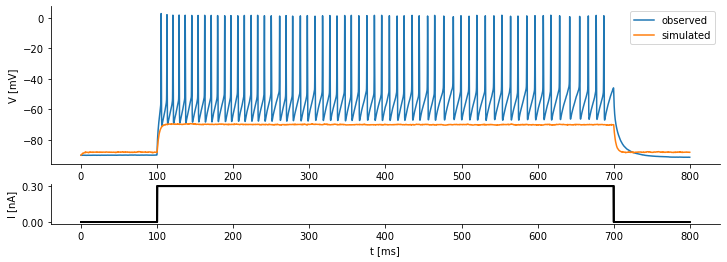

In [22]:
# parameters
cell_params = {"Description": "TestCell", "C": 1e-2, "Type": "Pvalb Calb1_1"}
exp_params = {"StimDur": 0.6, "StimOnset": 0.1, 
              "StimEnd": 0.7, "ObsTime" :1., 
              "IStep": 20*1e-12, "LiqJuncPotential": 15.4*1e-3,
              "Description": "20200403_sample_4", "Temp": 34}

# file location
observations = '../data/04_03_2020_sample_4.mat'

# selecting and fitting experimental data
ExpData = Data(observations, exp_params=exp_params, cell_params=cell_params)
ExpData.select_subset([2],t_cutoff=0.8)
ExpData.fitcell2observations(show=False)
ExpData.set_syn_current(141*1e6,6*1e-3)

# selecting observation and HH parameters
trace_obs = ExpData.Observations_selected[25]

param_guess = {r'$g_{Na}$': 9.0191374e+00, r'$g_{K}$': 1.7598242e+01,
                r'$g_{M}$': 3.7206849e-01, r'$g_{leak}$': 3.8078189e-01,
                r'$\tau_{max}$': 9.8968518e+02, r'$V_{T}$': -6.3518044e+01,
                r'$E_{leak}$': -8.8042015e+01, 'time constant factor': 0.6}

param_vec = np.array(list(param_guess.values())).reshape(1,-1)

# simulating trace
trace_sim = runHH(param_vec, trace=trace_obs)
axs = trace_obs.inspect(label="observed")
trace_sim.inspect(label="simulated", axes=axs)
plt.show()

In [23]:
# specifying prior and sampling parameters
#prior_min = [.5, 1e-4, 1e-4, 1e-4, 50, -90, -100, 0.1]
#prior_max = [80., 30, 0.6, 0.6, 3000, -40, -35, 3]
prior_min = [.5, 1e-4, 1e-4, 1e-4, 50, -90, -110, 0.1,-110*1e-3, 5*1e-10]
prior_max = [80., 30, 0.6, 0.6, 3000, -40, -50, 3,-50*1e-3, 5*1e-9]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))

In [13]:
import time
test_sample = prior.sample((1000,))

t0 = time.time()
summaries = simulate_and_summarise_batches(test_sample, trace_obs.get_syn_current(),
                                          using="c2", mode="model_params",
                                          batch_size=25, num_workers=1)
t1 = time.time()

print("Simulation and Summarisation time was: {} sec".format(t1-t0) )

WARNING    /home/jnsbck/Applications/anaconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:539: RuntimeWarning: invalid value encountered in log
 [py.warnings]

WARNING    /home/jnsbck/Applications/anaconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:539: RuntimeWarning: invalid value encountered in log
 [py.warnings]

WARNING    /home/jnsbck/Applications/anaconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:539: RuntimeWarning: invalid value encountered in log
 [py.warnings]

WARNING    /home/jnsbck/Applications/anaconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:539: RuntimeWarning: invalid value encountered in log
 [py.warnings]

WARNING    /home/jnsbck/Applications/anaconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:539: RuntimeWarning: invalid value encountered in log
 [py.warnings]

WARNING    /home/jnsbck/Applications/anaconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_la


Simulation and Summarisation time was: 45.271146297454834 sec


In [60]:
# run simulations from the prior samples and collect the results
theta = prior.sample((2000,))

simulated_traces = simulate_batches(theta, trace_obs=trace_obs, num_workers=2)
summaries = summarise_batches(simulated_traces) #num of workers > 1 works only if Trace is imported from Module

stats_obs = pd.DataFrame([pd.Series(trace_obs.summarise())])
stats_sim = pd.DataFrame(np.array(summaries), columns=stats_obs.columns)
params_sim = pd.DataFrame(np.array(theta), columns=param_guess.keys())
sim_results_df = pd.concat([params_sim, stats_sim], axis=1)

WARNING    /home/jnsbck/Applications/anaconda3/envs/sbi_env/lib/python3.7/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
 [py.warnings]
WARNING    /home/jnsbck/Applications/anaconda3/envs/sbi_env/lib/python3.7/site-packages/scipy/stats/stats.py:1086: RuntimeWarning: overflow encountered in square
  s = a_zero_mean**2
 [py.warnings]
WARNING    /home/jnsbck/Applications/anaconda3/envs/sbi_env/lib/python3.7/site-packages/scipy/stats/stats.py:1090: RuntimeWarning: overflow encountered in square
  s = s**2
 [py.warnings]
WARNING    /home/jnsbck/Applications/anaconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:325: RuntimeWarning: invalid value encountered in true_divide
 [py.warnings]


In [ ]:
PATH = "../data/saved_stats/{0}_{1}paramprior_stats_Iscale1.csv".format(ExpData.Description, len(params_sim.columns))

# export stats to csv
sim_results_df.to_csv(PATH, index=False)

In [ ]:
# import stats from csv
PATH = "../data//saved_stats/{0}_{1}paramprior_stats_Iscale1.csv".format(ExpData.Description, len(params_sim.columns))

sim_results_df = pd.read_csv(PATH)
sim_results_df.head()

n_params = 8
params_sim, stats_sim = sim_results_df.iloc[:,:n_params], sim_results_df.iloc[:,n_params:]
stats_sim.head()

In [32]:
# import
theta = np.load('../data/saved_stats/{}_8paramprior_stats_Iscale1.npz'.format(ExpData.Description))['theta']
stats = np.load('../data/saved_stats/{}_8paramprior_stats_Iscale1.npz'.format(ExpData.Description))['stats']
theta = theta[:stats.shape[0],:] # why !?

stats_obs = pd.DataFrame([pd.Series(trace_obs.summarise())])
params_sim = pd.DataFrame(data=theta, columns=list(param_guess.keys())) 
stats_sim = pd.DataFrame(data=stats, columns=stats_obs.columns)

In [167]:
prior_min = [.5, 1e-4, 1e-4, 1e-4, 50, -90, -110, 0.1,-110*1e-3, 5*1e-10]
prior_max = [80., 30, 0.6, 0.6, 3000, -40, -50, 3,-50*1e-3, 5*1e-9]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))
trial = prior.sample((1,))
#print(trial.shape)
sim_trace = runHH(trial[:,:-2], syn_current=trace_obs.get_syn_current(), mode="trace", using="p")
#sim_trace.inspect()

#print(trial.shape)
sim_trace = runHH(trial, syn_current=trace_obs.get_syn_current(), mode="model_params", using="p")
#sim_trace.inspect()

torch.Size([1, 8]) 1 -90.03511547446249 [0. 0. 0. ... 0. 0. 0.]
torch.Size([1, 8]) 1 -57.04355239868164 [0. 0. 0. ... 0. 0. 0.]


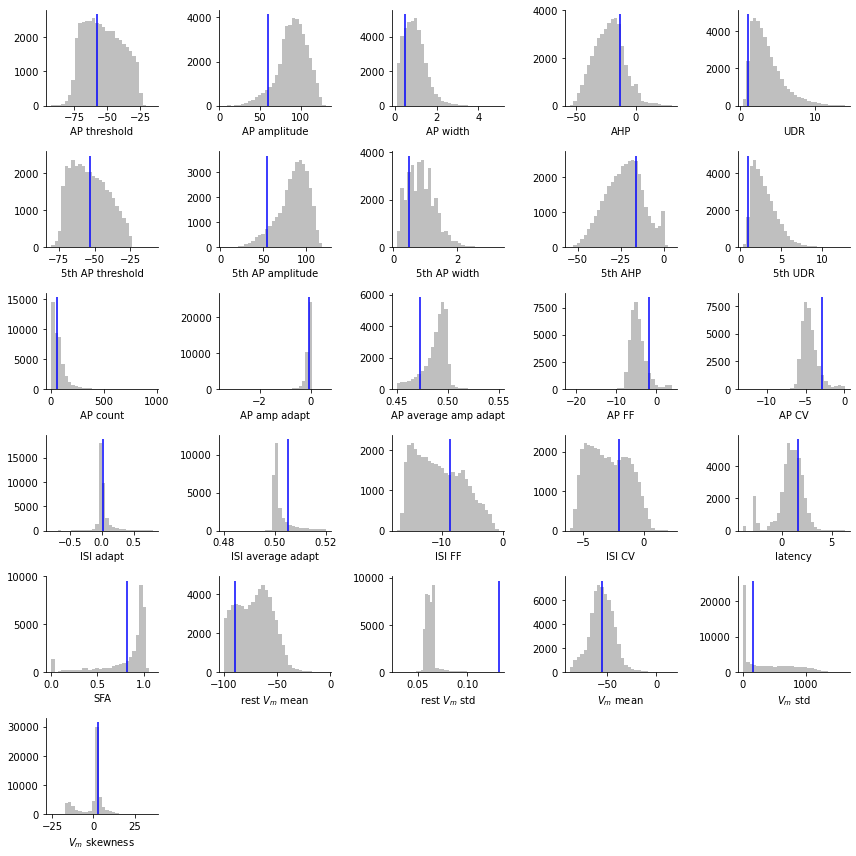

In [35]:
plot_summary_stats(stats_sim, stats_obs)

In [33]:
selected_indices = [0,1,2,3,5,6,7,8,10,11,12,14,15,18,19,20,21,23,24,25]
selected_metrics = stats_sim.columns[selected_indices]
na_idx = stats_sim.T.isna().any()
#stats_sim.columns[[4,9,13,16,17,22]]

stats_obs_selected = stats_obs[selected_metrics]
stats_sim_selected = stats_sim[selected_metrics].loc[~na_idx]
thetas_selected = params_sim.loc[~na_idx]
#traces_selected = np.array(results)[~na_idx]

stats_sim_selected_norm = normalise_df(stats_sim_selected)
#stats_obs_selected_norm = normalise(stats_obs_selected)

In [ ]:
MSE = np.sum(np.square(stats_sim_selected_norm.values - stats_obs_selected.values), axis=1)
min_MSE = np.sort(MSE)[:10]
min_MSE_idx = np.argsort(MSE)[:10]

best_params = thetas_selected.iloc[min_MSE_idx]

fig, axes = plt.subplots(5, 2, figsize = (10, 14))
for i, (ax, sim_result) in enumerate(zip(axes.reshape(-1),traces_selected[min_MSE_idx])):
    sim_result.inspect(axes=ax, label="simulated", voltage_only=True)
    trace_obs.inspect(axes=ax, label="observed", voltage_only=True)
    ax.set_ylabel('Membrane voltage (mV)', fontsize = 15)
    ax.set_xlabel('Time (ms)', fontsize = 15)
    ax.set_title('Simulation {}'.format(i), fontsize = 17)
plt.tight_layout()
plt.show()

In [34]:
import sbi.utils as utils
from sbi.inference import SNPE, prepare_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi.utils import pairplot, conditional_pairplot, conditional_corrcoeff, eval_conditional_density

In [39]:
Itest = np.array(trace_obs.get_syn_current()["ItA"]/trial[:,9].reshape(-1,1)*1e14)
#Itest = np.array(trace_obs.get_syn_current()["ItA"]/trial[:,9].reshape(1,-1)*1e14)
I = br2.TimedArray(np.vstack( [Itest] ), dt = 0.04*br2.msecond)
print(I.values.shape)

(25, 20000)


In [35]:
prior_min = [.5, 1e-4, 1e-4, 1e-4, 50, -90, -100, 0.1]
prior_max = [80., 30, 0.6, 0.6, 3000, -40, -35, 3]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))

simulate_obs_trace = lambda params: simulate_and_summarise_batches(params, trace=trace_obs, selected_stats=selected_indices)
simulator, prior = prepare_for_sbi(simulate_obs_trace, prior)

density_estimator_build_fun = posterior_nn(model='mdn') # Here you could change your model e.g. to 'maf' or 'nsf' 

TypeError: simulate_and_summarise_batches() got an unexpected keyword argument 'trace'

In [83]:
inference = SNPE(prior, density_estimator=density_estimator_build_fun, 
                 show_progress_bars=True) # num_workers is not supported anymore

density_estimator = inference.append_simulations(torch.as_tensor(thetas_selected.values, dtype=torch.float32), \
                               torch.as_tensor(stats_sim_selected.values, dtype=torch.float32)).train()

posterior = inference.build_posterior(density_estimator)  # MCMC kwargs go here.

WARNING    /home/jnsbck/Applications/anaconda3/envs/sbi_env/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag
 [py.warnings]
  allow_unreachable=True)  # allow_unreachable flag



Neural network successfully converged after 243 epochs.


In [30]:
#torch.save(posterior, "./trained_posteriors/nsf_posterior_"+ ExpData.Description)
posterior = torch.load("./trained_posteriors/mdn_posterior_"+ ExpData.Description)

In [31]:
#samples = posteriors[0].sample((20000,), x=stats_obs_selected.values)
samples = posterior.sample((20000,), x=stats_obs_selected.values)

NameError: name 'stats_obs_selected' is not defined

In [95]:
posterior.set_default_x(stats_obs_selected.values)
most_probable_samples = np.array(np.argsort(posterior.log_prob(samples)))[::-1]
idx_p_max = most_probable_samples[0]
print("highest posterior probability by index", most_probable_samples)

highest posterior probability by index [13644 13944 19548 ... 18845 11139 16524]


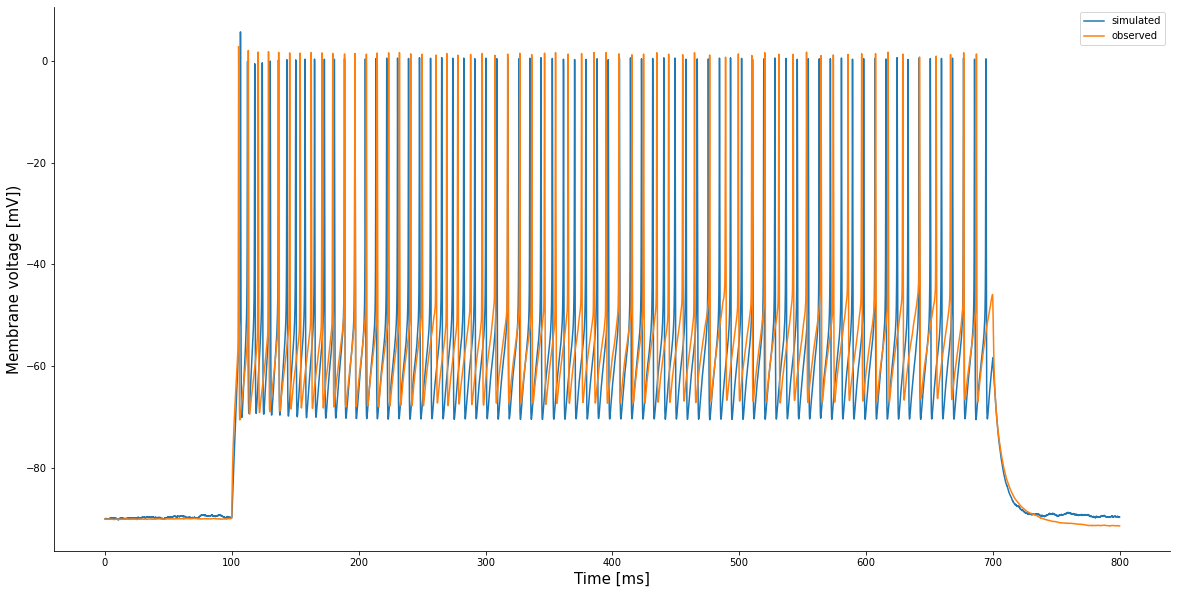

In [97]:
plot_comparison(runHH(samples[idx_p_max],trace_obs), trace_obs, figsize=(20,10))

In [96]:
output_traces = []
num_sims = 2000
for i in range(num_sims):
    print("\rRunning Simulation {}/{}".format(i+1,num_sims), end=" ")
    trace_out = runHH(np.array(samples[i,:]),trace_obs)
    output_traces.append(trace_out)

Running Simulation 2000/2000 

In [97]:
closest_idxs, closest_traces = best_matches_std(output_traces, trace_obs, selected_stats=selected_indices, accept_radius=11)
closest_samples = samples[closest_idxs]

In [98]:
d_max_idxs = greatest_distance(closest_samples)

In [99]:
min_MSE_idx, min_MSE = best_matches_MSE(np.array(output_traces), trace_obs, selected_stats=selected_indices)

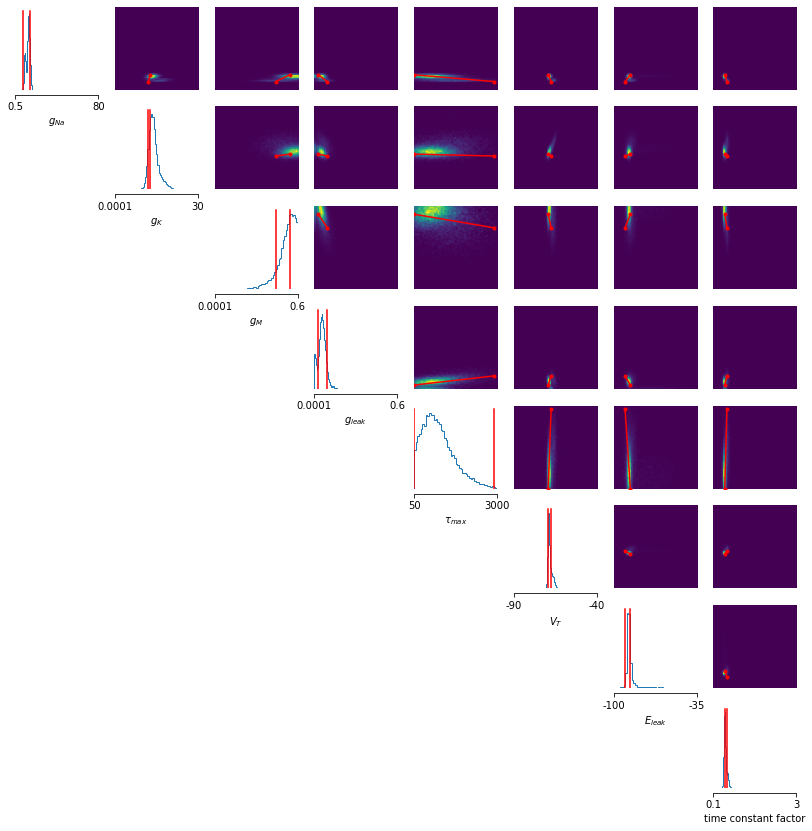

In [210]:
fig, axes = utils.pairplot(samples,
                           limits=list(zip(prior_min,prior_max)),
                           ticks=list(zip(prior_min,prior_max)),
                           points=closest_samples[[d_max_idxs]],
                           fig_size=(14,14),
                           labels=list(param_guess.keys()),
                           points_offdiag={'markersize': 6},
                           points_colors='r');
#plt.savefig('./figures/{}/posterior_distribution_Iscale1.png'.format(cell_name))

In [101]:
theta_s, theta_g = closest_samples[[d_max_idxs]]

In [102]:
from sbi.utils.conditional_density import eval_conditional_density

Progress: (1500/1500)

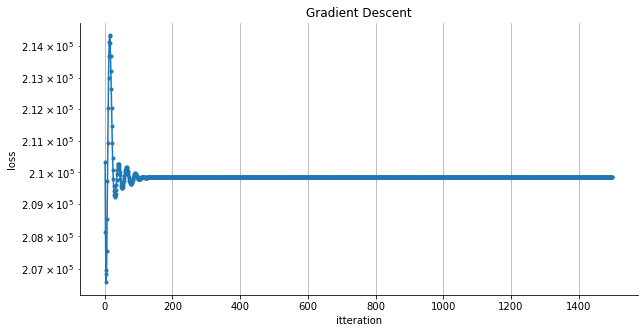

In [749]:
#%matplotlib notebook
path = fit_high_posterior_path(theta_s, theta_g, posterior, stats_obs_selected.values, n_components=5)

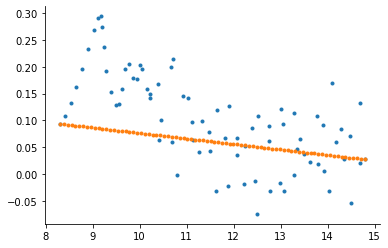

In [736]:
path_s = gamma(torch.linspace(0,1,80),5e-2*torch.rand((8,5)),5, theta_g=theta_g, theta_s=theta_s).detach().T
plt.plot(path_s[:,0],path_s[:,3], ".")
plt.plot(path[:,0],path[:,3], ".")

In [36]:
from sbi.inference.posteriors.direct_posterior import DirectPosterior
from copy import deepcopy

In [398]:
mdn_post = MDNPosterior(posterior)

In [399]:
sample = posterior.sample((10,))
mdn_post = MDNPosterior(posterior)
print(posterior.log_prob(sample), mdn_post.log_prob(sample))


tensor([ -5.1215,  -6.4699, -10.6503,  -6.5294,  -4.9535,  -6.0782,  -4.2509,
         -4.5350,  -7.9979,  -9.2317]) [ -5.12145082  -6.46987573 -10.65025403  -6.52942728  -4.95345578
  -6.07818555  -4.25093982  -4.53501708  -7.99790264  -9.23168656]


In [995]:
mdn_post = MDNPosterior(posterior)
#print(mdn_post.log_prob(mdn_post.m[0]),posterior.log_prob(mdn_post.m[0]))
#mdn_cond_post = ConditionalMDNPosterior(mdn_post, sample)

In [940]:
mdn_cond_post = mdn_post.conditionalise(sample)

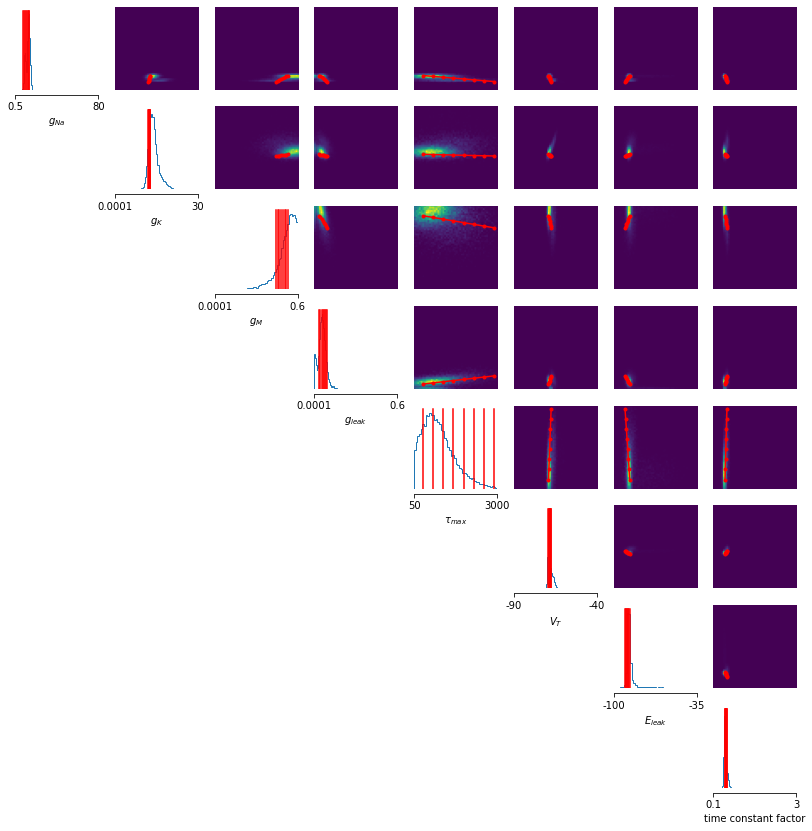

In [737]:
fig, axes = utils.pairplot(samples,
                           limits=list(zip(prior_min,prior_max)),
                           ticks=list(zip(prior_min,prior_max)),
                           points=path[::10],
                           fig_size=(14,14),
                           labels=list(param_guess.keys()),
                           points_offdiag={'markersize': 6},
                           points_colors='r');
#plt.savefig('./figures/{}/posterior_distribution_Iscale1.png'.format(cell_name))

In [ ]:
#plot_comparison(np.array(output_traces)[closest_idxs], trace_obs)

In [35]:
#out = eval_conditional_density(posterior,condition, limits=np.array([[.5,80], [1e-4,30], [1e-4,0.6], [1e-4,0.6], [50, 3000], [-90,-40],\
#                                  [-100,-35],[.1,3]]), dim1=0, dim2=0)
#plt.imshow(out)
#posterior.log_prob(condition)

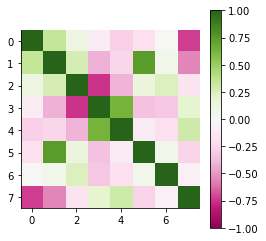

In [92]:
posterior.set_default_x(stats_obs_selected.values)

corr_matrix_marginal = np.corrcoef(samples.T)
fig, ax = plt.subplots(1,1, figsize=(4, 4))
im = plt.imshow(corr_matrix_marginal, clim=[-1, 1], cmap='PiYG')
_ = fig.colorbar(im)

In [93]:
#condition = samples[min_MSE_idx[0]]#.reshape([1,8]) # WATCH OUT !!! CRUCIAL FOR THE COND CORR TO WORK
condition = samples[idx_p_max]
print("p =", float(np.exp(posterior.log_prob(condition))))

p = 4805.0087890625


In [94]:
condition = closest_samples[0]

In [90]:
#condition = posterior.sample((1,))
#condition = torch.as_tensor(param_vec.astype("float32"))
#print("p =", float(np.exp(posterior.log_prob(condition))))

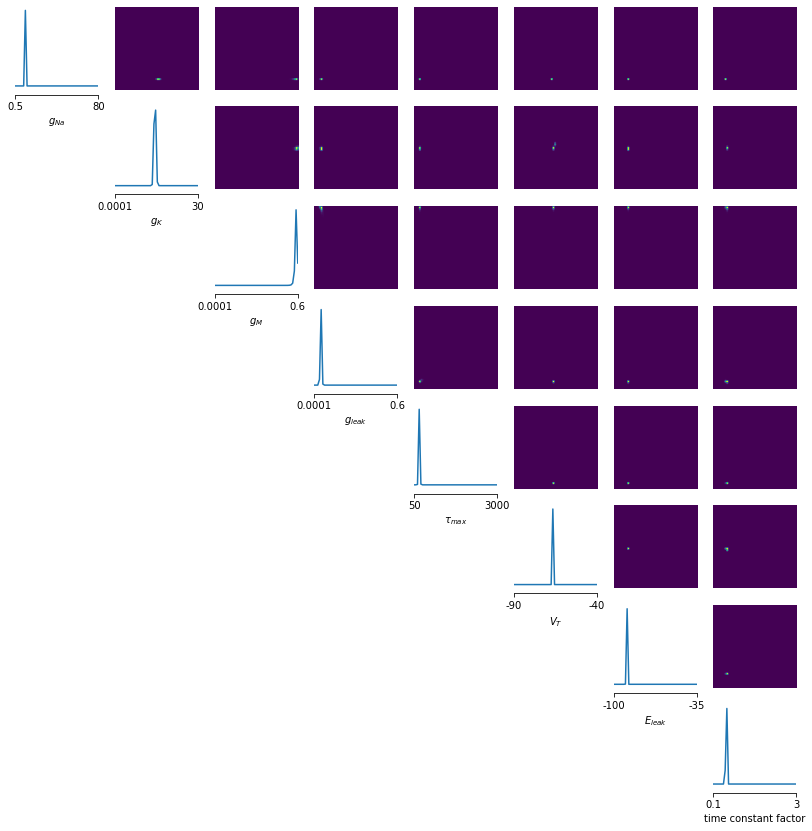

In [95]:
_ = conditional_pairplot(
    density=posterior,
    condition=condition,
    #points=closest_samples[[d_max_idxs]],
    limits=list(zip(prior_min,prior_max)),
    ticks=list(zip(prior_min,prior_max)),
    fig_size=(14,14),
    points_offdiag={'markersize': 6},
    points_colors='r',
    labels=list(param_guess.keys()),
)

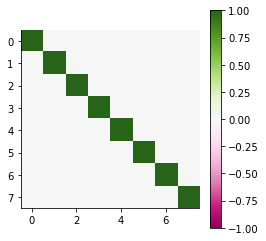

In [96]:
cond_coeff_mat = conditional_corrcoeff(density=posterior,
                                       condition=condition,
                                       limits=torch.Tensor(list(zip(prior_min,prior_max))))
fig, ax = plt.subplots(1,1, figsize=(4,4))
im = plt.imshow(cond_coeff_mat, clim=[-1, 1], cmap='PiYG')
_ = fig.colorbar(im)

<Figure size 1080x720 with 0 Axes>

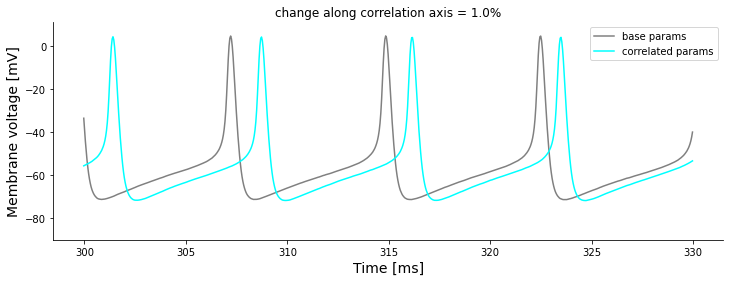

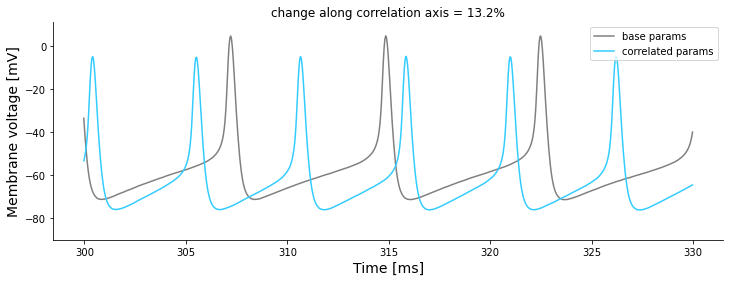

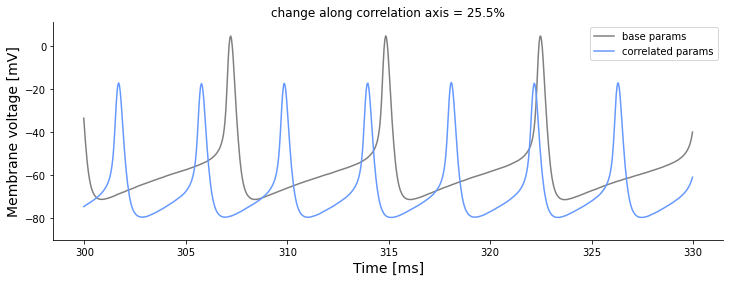

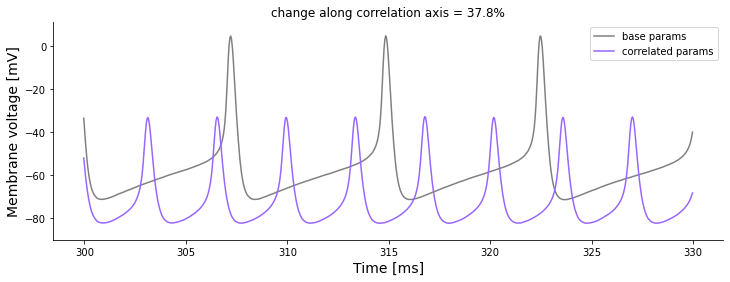

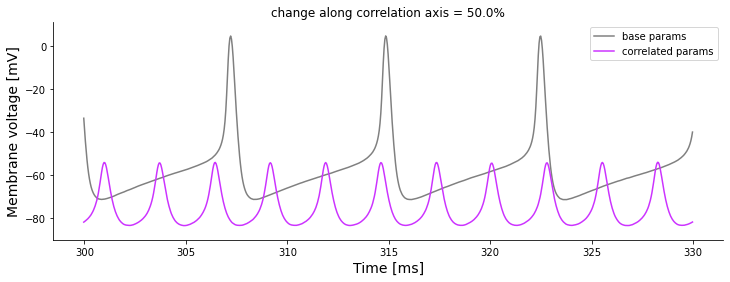

In [108]:
#plot_correlation_effects(condition, trace_obs.get_syn_current(), cond_coeff_mat, mag_of_change=0.1, figsize=(15,10), timewindow=[0.3,0.35], effect_on="summary_stats", selected_stats=selected_indices)
#plot_correlation_effects(condition, trace_obs.get_syn_current(), cond_coeff_mat, mag_of_change=0.1, figsize=(15,10), timewindow=[0.3,0.35], effect_on="traces")
show_correlated_traces(condition, trace_obs.get_syn_current(), cond_coeff_mat, pair=(1,5))

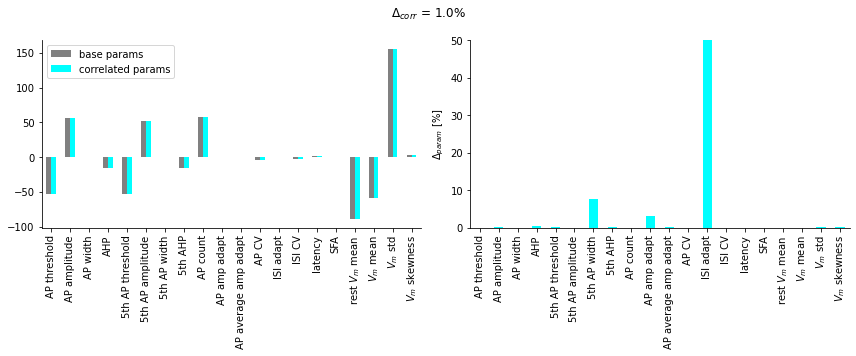

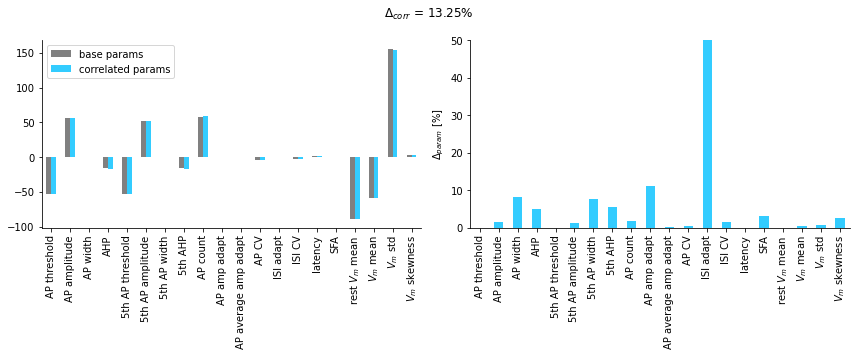

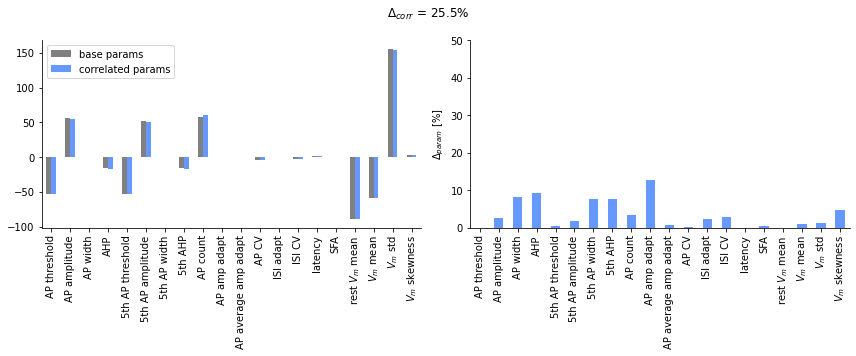

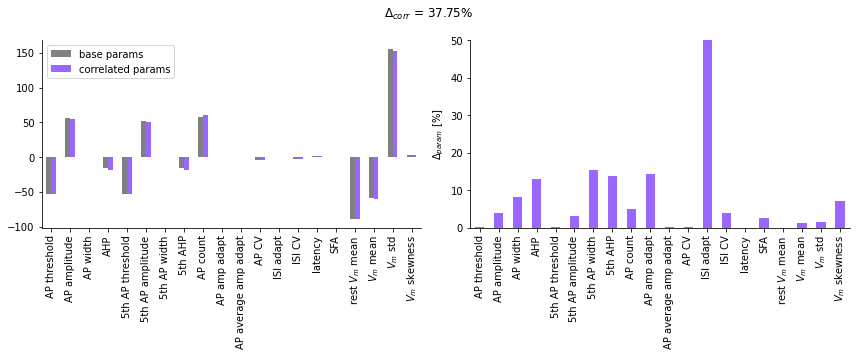

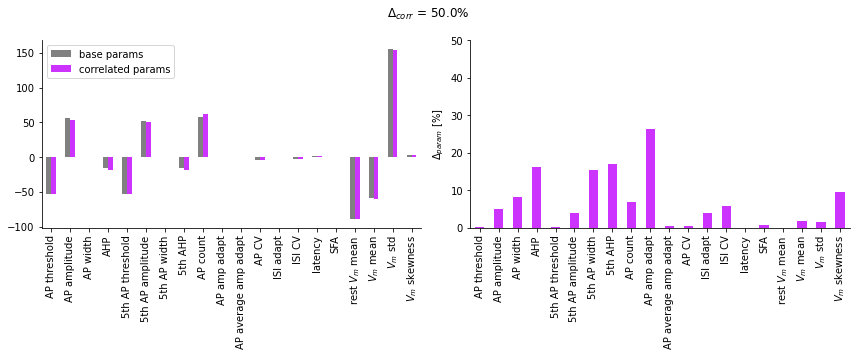

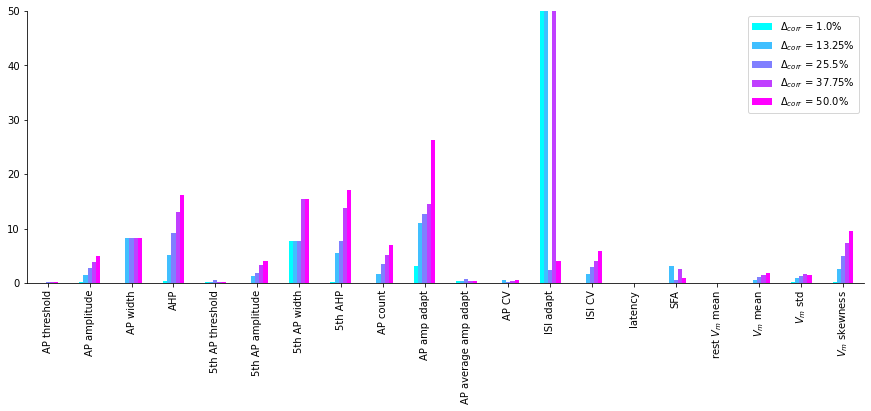

In [140]:
#plot_correlated_summary_stats(condition, trace_obs.get_syn_current(), cond_coeff_mat, selected_stats=selected_indices, pair=(1,4))
#show_correlated_traces(condition, trace_obs.get_syn_current(), cond_coeff_mat, pair=(2,6))